# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import tqdm

!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments, pipeline)

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

Mounted at /content/drive
cuda:0


# INITIAL PREDICTING USING TRAINED MODEL



CAN DELETE THIS AFTER

In [5]:
intents_tweetset = pd.read_excel("/content/drive/My Drive/preproc_data/training_data/intents_tweetset.xlsx",sheet_name='Sheet1', header=0)
train = pd.read_excel("/content/drive/My Drive/preproc_data/training_data/train.xlsx",sheet_name='Sheet1', header=0)
dev = pd.read_excel("/content/drive/My Drive/preproc_data/training_data/dev.xlsx",sheet_name='Sheet1', header=0)
test = pd.read_excel("/content/drive/My Drive/preproc_data/training_data/newtest.xlsx",sheet_name='Sheet1', header=0)

def extract_topic_intent(string):
    words = string.split(':')
    return words[0]

import json

with open('/content/drive/My Drive/preproc_data/training_data/idx2topicset.json') as json_file:
    idx2topicset = json.load(json_file)

with open('/content/drive/My Drive/preproc_data/training_data/idx2intentset.json') as json_file:
    idx2intentset = json.load(json_file)

intents_train_indices = train['index'].values
intents_dev_indices = dev['index'].values
intents_test_indices = test['index'].values

intents_train_intents = []
for i, index in enumerate(intents_train_indices):
    intents_train_intents.append(idx2intentset[str(int(index))])

intents_dev_intents = []
for i, index in enumerate(intents_dev_indices):
    intents_dev_intents.append(idx2intentset[str(int(index))])

intents_test_intents = []
for i, index in enumerate(intents_test_indices):
    intents_test_intents.append(idx2intentset[str(int(index))])

intents_train = pd.DataFrame()
intents_train['index'] = intents_train_indices
intents_train['tweet'] = train['tweet'].values
intents_train['topic'] = train['topic'].values
intents_train['intent'] = np.array(intents_train_intents)

intents_dev = pd.DataFrame()
intents_dev['index'] = intents_dev_indices
intents_dev['tweet'] = dev['tweet'].values
intents_dev['topic'] = dev['topic'].values
intents_dev['intent'] = np.array(intents_dev_intents)

intents_test = pd.DataFrame()
intents_test['index'] = intents_test_indices
intents_test['tweet'] = test['tweet'].values
intents_test['topic'] = test['topic'].values
intents_test['intent'] = np.array(intents_test_intents)


!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments, pipeline)

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction


!pip install emoji
from emoji import demojize
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet, tweet_tokenizer):
    tokens = tweet_tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

# GET TENSORS
def get_tensors(tweets):

    tweet_tokenizer = TweetTokenizer()
    input_ids = []
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-covid19-base-cased")

    for tweet in tqdm.tqdm(tweets):
        normalized_tweet = normalizeTweet(tweet, tweet_tokenizer)
        input_ids.append(normalized_tweet)

    torch_tweets = tokenizer.batch_encode_plus(batch_text_or_text_pairs=input_ids, is_split_into_words=True, padding='max_length', truncation=True, max_length=107)

#     list_of_inputs = torch_tweets['input_ids']
#     tensors = []

#     for record in list_of_inputs:
#         tensors.append(torch.tensor(record))

#     tensors = torch.stack(tensors)

    return torch_tweets

# ONLY FOR MAIN TOPICS #
def get_main_topics(idx2topicset):
    idx2maintopics = {}

    for key, value in idx2topicset.items():
        maintopics = set()
        for topic in value:
            maintopics.add(extract_topic_intent(topic))

        idx2maintopics[key] = list(maintopics)

    return idx2maintopics

# GET MLB
def get_mlb(idx2topic):
    all_topics = list(idx2topic.values())
    all_indices = list(idx2topic.keys())

    mlb = MultiLabelBinarizer()
    allbinarizedlabels = mlb.fit_transform(all_topics)

    idx2binarizedlabel = {}
    for i, key in enumerate(all_indices):
        idx2binarizedlabel[key] = allbinarizedlabels[i]

    return mlb, idx2binarizedlabel

def get_mlb(idx2intent):
    all_intents = list(idx2intent.values())
    all_indices = list(idx2intent.keys())

    mlb = MultiLabelBinarizer()
    allbinarizedlabels = mlb.fit_transform(all_intents)

    idx2binarizedlabel = {}
    for i, key in enumerate(all_indices):
        idx2binarizedlabel[key] = allbinarizedlabels[i]

    return mlb, idx2binarizedlabel

def get_joint_labels(index_values, idx2binarizedtopiclabel, idx2binarizedintentlabel):
  labels = []
  for index in index_values:
      labels.append(torch.cat((torch.tensor(idx2binarizedtopiclabel[str(int(index))]), torch.tensor(idx2binarizedintentlabel[str(int(index))]))))

  labels = torch.stack(labels)

  return labels

# GET LABELS
def get_labels(index_values, idx2binarizedlabel):

    labels = []
    for index in index_values:
        labels.append(torch.tensor(idx2binarizedlabel[str(int(index))]))

    labels = torch.stack(labels)

    return labels

idx2maintopics = get_main_topics(idx2topicset)
idx2mainintents = get_main_topics(idx2intentset)
topic_mlb, idx2binarizedtopiclabel = get_mlb(idx2maintopics)
intent_mlb, idx2binarizedintentlabel = get_mlb(idx2mainintents)
joint = True
intent_bool = False
topic_bool = False

# PREPARING TEST DATA

test_tensors = get_tensors(test['tweet'].values)

test_labels = None

if intent_bool == True:
  test_labels = get_joint_labels(test['index'].values, idx2binarizedintentlabel)

if topic_bool == True:
  test_labels = get_joint_labels(test['index'].values, idx2binarizedtopiclabel)

if joint == True:
  test_labels = get_joint_labels(test['index'].values, idx2binarizedtopiclabel, idx2binarizedintentlabel)

from sklearn.metrics import classification_report

def get_hyperparams(lr, tbs, ebs, epochs, wd):
  hyperparams = {}
  hyperparams['learning_rate'] = lr
  hyperparams['train_batch_size'] = tbs
  hyperparams['eval_batch_size'] = ebs
  hyperparams['num_train_epochs'] = epochs
  hyperparams['weight_decay'] = wd

  return hyperparams

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(predictions).cpu()
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1_micro': f1_micro_average,
               'f1_macro': f1_macro_average,
               'roc_auc_micro': roc_auc,
               'accuracy': accuracy}
    return metrics

def generate_results(predictions, labels, classes, hyperparams, filenum, threshold=0.5):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(predictions).cpu()
  # next, use threshold to turn them into integer predictions
  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs >= threshold)] = 1

  y_true = labels
  report = classification_report(y_true, y_pred, output_dict=True, target_names=classes)

  metrics = multi_label_metrics(predictions, labels, threshold=0.5)

  results_Df = pd.DataFrame.from_dict(report, orient='index').reset_index()
  results_Df.rename(columns={'index':'label'}, inplace=True)
  results_Df.loc[len(results_Df.index)] = ['roc_auc_micro', metrics['roc_auc_micro'], '--', '--', '--']
  results_Df.loc[len(results_Df.index)] = ['accuracy', metrics['accuracy'], '--', '--', '--']

  results_Df['learning_rate'] = hyperparams['learning_rate']
  results_Df['train_batch_size'] = hyperparams['train_batch_size']
  results_Df['eval_batch_size'] = hyperparams['eval_batch_size']
  results_Df['num_train_epochs'] = hyperparams['num_train_epochs']
  results_Df['weight_decay'] = hyperparams['weight_decay']
  results_Df.set_index(['num_train_epochs', 'learning_rate','train_batch_size', 'eval_batch_size', 'weight_decay', 'label'], inplace=True)

  filename = 'results_' + str(filenum) + '.csv'
  results_Df.to_csv(filename)

  return results_Df


classes = None

if intent_bool == True:
  classes = list(intent_mlb.classes_)

if topic_bool == True:
  classes = list(topic_mlb.classes_)

if joint == True:
  classes = list(topic_mlb.classes_) + list(intent_mlb.classes_)

id2label = {idx:label for idx, label in enumerate(classes)}
label2id = {label:idx for idx, label in enumerate(classes)}


input_ids = test_tensors['input_ids']
attention_mask = test_tensors['attention_mask']
token_type_ids = test_tensors['token_type_ids']

input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)

class CovidData(Dataset):
    def __init__(self, inputs, attention):
        self.inputs = inputs
        self.atts = attention

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        return self.inputs[index], self.atts[index]

testdata = CovidData(input_ids, attention_mask)
covid_data = DataLoader(testdata, batch_size=32, shuffle=False)
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/My Drive/preproc_data/saved_model').to(device)
model.eval()

outputs = []

with torch.no_grad():
  for inputs, atts in tqdm.tqdm(covid_data):
    inputs_dev = inputs.to(device)
    atts_dev = atts.to(device)
    output = model(input_ids=inputs_dev, attention_mask=atts_dev)
    outputs.append(output)
    torch.cuda.empty_cache()

outputs_tensors = [outputs[i].logits for i in range(len(outputs))]
outputs_tensors = torch.vstack(outputs_tensors)


classes = {0: 'CAUSE',
 1: 'ECONOMY AND SOCIETY',
 2: 'HEALTHCARE',
 3: 'MISINFORMATION',
 4: 'OTHER',
 5: 'PREVENTION',
 6: 'RESOURCE',
 7: 'SYMPTOMS AND SPREAD',
 8: 'TREATMENT',
 9: 'CRITICIZE',
 10: 'HONOR',
 11: 'PRAISE',
 12: 'PREDICT',
 13: 'PROMOTE OWN WORK',
 14: 'PROVIDE INFORMATION',
 15: 'RECOMMEND',
 16: 'SEEK INFORMATION',
 17: 'SHARE STORY'}

class_names = list(classes.values())

threshold=0.5
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs_tensors).cpu()
# next, use threshold to turn them into integer predictions
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= threshold)] = 1


lr = 4e-5
tbs = 32
ebs = 32
epochs = 15
wd = 0.1

hyperparams = get_hyperparams(lr, tbs, ebs, epochs, wd)


results = generate_results(outputs_tensors, test_labels, classes, hyperparams, 0, threshold=0.5)

<ipython-input-5-f3981c1dff1b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  intents_train['intent'] = np.array(intents_train_intents)
<ipython-input-5-f3981c1dff1b>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  intents_dev['intent'] = np.array(intents_dev_intents)
<ipython-input-5-f3981c1dff1b>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when cre

100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


In [6]:
results

precision  \
num_train_epochs learning_rate train_batch_size eval_batch_size weight_decay label                      
15               0.00004       32               32              0.1          0               1.000000   
                                                                             1               1.000000   
                                                                             2               0.995192   
                                                                             3               1.000000   
                                                                             4               1.000000   
                                                                             5               1.000000   
                                                                             6               1.000000   
                                                                             7               1.000000   
                                                                             8               1.000000   
                                                                             9               1.000000   
                                                                             10              1.000000   
                                                                             11              1.000000   
                                                                             12              1.000000   
                                                                             13              1.000000   
                                                                             14              1.000000   
                                                                             15              0.982709   
                                                                             16              1.000000   
                                                                             17              0.980000   
                                                                             micro avg       0.997259   
                                                                             macro avg       0.997661   
                                                                             weighted avg    0.997311   
                                                                             samples avg     0.997997   
                                                                             roc_auc_micro   0.996978   
                                                                             accuracy        0.975322   

                                                                                              recall  \
num_train_epochs learning_rate train_batch_size eval_batch_size weight_decay label                     
15               0.00004       32               32              0.1          0              0.111111   
                                                                             1                   1.0   
                                                                             2                   1.0   
                                                                             3                   1.0   
                                                                             4              0.975309   
                                                                             5                   1.0   
                                                                             6               0.99005   
                                                                             7                   1.0   
                                                                             8                   1.0   
                                                                             9                   1.0   
                                                                             10                  1.0   
         

In [ ]:
(# input_ids = (torch.load('/content/drive/My Drive/preproc_data/input_ids.pt'))
# attention_mask = (torch.load('/content/drive/My Drive/preproc_data/attention_mask.pt'))

In [ ]:
# class CovidData(Dataset):
#     def __init__(self, inputs, attention):
#         self.inputs = inputs
#         self.atts = attention

#     def __len__(self):
#         return self.inputs.shape[0]

#     def __getitem__(self, index):
#         return self.inputs[index], self.atts[index]

In [ ]:
# alldata = CovidData(input_ids, attention_mask)

In [ ]:
# covid_data = DataLoader(alldata, batch_size=32, shuffle=False)

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained('/content/drive/My Drive/preproc_data/saved_model').to(device)

In [ ]:
# model.eval()

# outputs = []

# with torch.no_grad():
#   for inputs, atts in tqdm.tqdm(covid_data):
#     inputs_dev = inputs.to(device)
#     atts_dev = atts.to(device)
#     output = model(input_ids=inputs_dev, attention_mask=atts_dev)
#     outputs.append(output)
#     torch.cuda.empty_cache()

In [ ]:
# outputs_tensors = [outputs[i].logits for i in range(len(outputs))]

In [ ]:
# outputs_tensors = torch.vstack(outputs_tensors)

In [ ]:
# outputs_tensors.shape

In [ ]:
# torch.save(outputs_tensors, '/content/drive/My Drive/preproc_data/outputs_tensors.pt')

# LOADING PREDICTIONS AND ANALYSIS

In [ ]:
classes = {0: 'CAUSE',
 1: 'ECONOMY AND SOCIETY',
 2: 'HEALTHCARE',
 3: 'MISINFORMATION',
 4: 'OTHER',
 5: 'PREVENTION',
 6: 'RESOURCE',
 7: 'SYMPTOMS AND SPREAD',
 8: 'TREATMENT',
 9: 'CRITICIZE',
 10: 'HONOR',
 11: 'PRAISE',
 12: 'PREDICT',
 13: 'PROMOTE OWN WORK',
 14: 'PROVIDE INFORMATION',
 15: 'RECOMMEND',
 16: 'SEEK INFORMATION',
 17: 'SHARE STORY'}

outputs_tensors = torch.load('/content/drive/My Drive/preproc_data/outputs_tensors.pt')

class_names = list(classes.values())

threshold=0.5
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs_tensors).cpu()
# next, use threshold to turn them into integer predictions
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= threshold)] = 1

In [ ]:
data = pd.read_csv('/content/drive/My Drive/data.csv', header=0)

In [ ]:
pred_topics = []
pred_intents = []

for pred in y_pred:
  each_pred_topics = []
  each_pred_intents = []
  pred_list = list(pred)

  for i, p in enumerate(pred_list):
    if p == 1:
      if i <= 8:
        each_pred_topics.append(classes[i])
      else:
        each_pred_intents.append(classes[i])

  pred_topics.append(each_pred_topics)
  pred_intents.append(each_pred_intents)

pred_topics_array = np.array(pred_topics)
pred_intents_array = np.array(pred_intents)

preds = pd.DataFrame()
preds['year'] = (data['date_year'].values)
preds['month'] = data['date_month'].values
preds['day'] = data['date_day'].values
preds['place_full_name'] = (data['place_full_name'].values)
preds['place_name'] = (data['place_name'].values)
preds['country'] = (data['place_country'].values)
preds['user_name'] = data['user_name'].values
preds['user_description'] = data['user_description'].values
preds['tweet'] = (data['tweet'].values)
preds['pred_topics'] = pred_topics_array
preds['pred_intents'] = pred_intents_array

<ipython-input-6-dd7ee7bba508>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_topics_array = np.array(pred_topics)
<ipython-input-6-dd7ee7bba508>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_intents_array = np.array(pred_intents)


In [ ]:
preds.head()

,year,month,day,place_full_name,place_name,country,user_name,user_description,tweet,pred_topics,pred_intents
0,2020,1,10,NaN,NaN,NaN,Tom Sandora,"Hospital Epidemiologist @BostonChildrens, pedi...",CDC health advisory about the Chinese coronavi...,"[ECONOMY AND SOCIETY, HEALTHCARE, SYMPTOMS AND...","[PROVIDE INFORMATION, RECOMMEND]"
1,2020,1,23,NaN,NaN,NaN,"Ian Weissman, DO",Radiologist @DeptVetAffairs. Chair @RadiologyA...,Coronavirus outbreak: doctors use robot to tre...,"[HEALTHCARE, TREATMENT]",[PROVIDE INFORMATION]
2,2020,1,23,NaN,NaN,NaN,KingsportVijay,"Civil Surgeon, US Dept Of Homeland Security. N...",Snakes Are The Likely Source of China's Deadly...,"[ECONOMY AND SOCIETY, RESOURCE, SYMPTOMS AND S...","[PROVIDE INFORMATION, RECOMMEND]"
3,2020,1,23,NaN,NaN,NaN,Natasha Azzopardi M,Medical doctor - Director of Country Health Po...,The WHO Representative dealing with #coronavir...,"[ECONOMY AND SOCIETY, HEALTHCARE]","[PRAISE, PROVIDE INFORMATION]"
4,2020,1,23,NaN,NaN,NaN,Wondimu Yirga,"Public health specialist (RN, BSN,MPH), Regist...",CDC confirms first US case of coronavirus that...,"[ECONOMY AND SOCIETY, HEALTHCARE, SYMPTOMS AND...",[PROVIDE INFORMATION]


# LOCATION

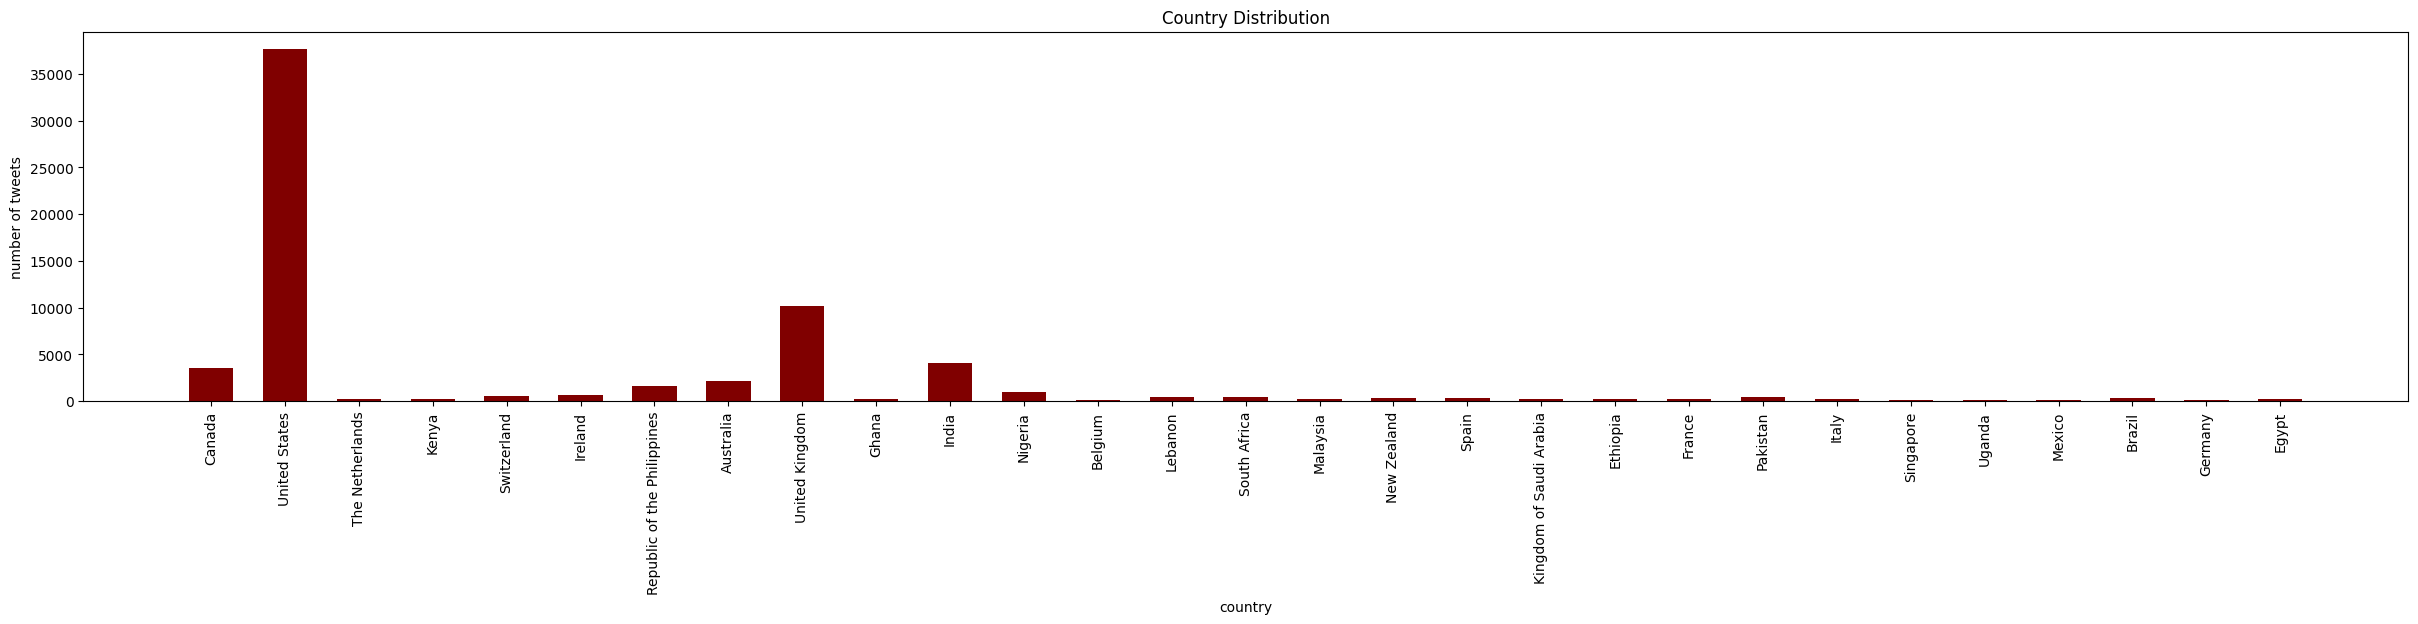

In [ ]:
locations = preds['country'].values

locations_dict = {}

for loc in locations:
  if loc in locations_dict:
    locations_dict[loc] += 1
  else:
    locations_dict[loc] = 1

locations_dict

trunc = {}
for key, val in locations_dict.items():
  if val >= 100:
    trunc[key] = val

locdict = pd.DataFrame()
locdict['loc'] = np.array(list(trunc.keys()))
locdict['freq'] = np.array(list(trunc.values()))

locdict.to_csv('/content/drive/My Drive/preproc_data/countrydict.csv')

plt.figure().set_figwidth(30)
plt.bar(locdict['loc'].values[1:], locdict['freq'].values[1:], color ='maroon',
        width = 0.6)
plt.xlabel("country")
plt.xticks(rotation='vertical')
plt.ylabel("number of tweets")
plt.title("Country Distribution")
plt.show()

## WITHIN U.S.

In [ ]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
    "USA": 'nan'
}

# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

predsUS = preds.loc[preds['country'] == 'United States']

locations = predsUS['place_full_name'].values
results = pd.read_csv('/content/drive/My Drive/preproc_data/location_results.csv', header=0)
states = results['state'].values
names = results['name'].values

name2state = {names[i]:states[i] for i in range(results.shape[0])}

In [ ]:
locations_dict = {}
nons_dict = {'Atlanta': 'Georgia',
 'Bronx': 'New York',
 'Brooklyn': 'New York',
 'Chicago': 'Illinois',
 'Columbus': 'Ohio',
 'Ear': 'nan',
 'Houston': 'Texas',
 'Inc.': 'nan',
 'Japan': 'nan',
 'Johns Hopkins Medicine': 'Maryland',
 'Los Angeles': 'California',
 'Manhattan': 'New York',
 'Missouri': 'Missouri',
 'NY (14610)': 'New York',
 'Philadelphia': 'Philadelphia',
 'Portland': 'Oregon',
 'Puerto Rico': 'nan',
 'Queens': 'New York',
 'Raphael Meadow Health Center': 'New Jersey',
 'San Diego': 'California',
 'San Francisco': 'California',
 'Seattle': 'Washington',
 'Virgin Islands': 'nan',
 'Washington': 'Washington',
 'West Campus - Farr Building': 'Massachusetts'}

city_state = {}
statevals = []
locations = preds['place_full_name'].values
places = preds['place_name'].values
countries = preds['country'].values
nons = set()

for i, key in enumerate(locations):
  country = countries[i]

  if pd.isnull(country):
    statevals.append('nan')
    continue
  else:
    if country == 'United States':
      if pd.isnull(key):
        statevals.append('nan')
      else:
        sep = key.split(", ")
        if len(sep) == 1:
          state = sep[0]
          if 'Varies' in state or 'Depending' in state or 'Unknown' in state:
            statevals.append('nan')
          elif 'United States' in state:
            statevals.append('nan')
          else:
            ans = name2state[sep[0]]
            if pd.isnull(ans):
              statevals.append('nan')
            elif 'Varies' in ans or 'Depending' in ans or 'Unknown'in ans or 'Dependent' in ans:
              statevals.append('nan')
            else:
              statevals.append(ans)
        else:
          if sep[1] in abbrev_to_us_state:
            statevals.append(abbrev_to_us_state[sep[1]])
          else:
            if sep[1] == 'USA':
              if places[i] in us_state_to_abbrev:
                statevals.append(places[i])
              else:
                statevals.append('nan')
            else:
              statevals.append(nons_dict[sep[1]])
    else:
      statevals.append('nan')


preds['state'] = np.array(statevals)


# city_state['East Meadow'] = 'New York'
# city_state['Hollywood'] = 'California'
# city_state['New York City'] = 'New York'
# city_state['Columbia Heights'] = 'Minnesota'

# notindf = pd.DataFrame()
# notindf['name'] = np.array(notin)
# notindf.to_csv('/content/drive/My Drive/preproc_data/notin.csv')

# trunc = {}
# for key, val in locations_dict.items():
#   if val >= 50:
#     trunc[key] = val

# locdict = pd.DataFrame()
# locdict['loc'] = np.array(list(trunc.keys()))
# locdict['freq'] = np.array(list(trunc.values()))

# locdict.to_csv('/content/drive/My Drive/preproc_data/USplacesdict.csv')

# plt.figure(figsize=(60,60))
# plt.bar(locdict['loc'].values, locdict['freq'].values, color ='maroon',
#         width = 0.6)
# plt.xlabel("place name")
# plt.xticks(rotation='vertical', fontsize=18)
# plt.ylabel("number of tweets")
# plt.title("Place Name Distribution")
# plt.show()

In [ ]:
# preds.to_csv('/content/drive/My Drive/preproc_data/PREDS/preds_all.csv')

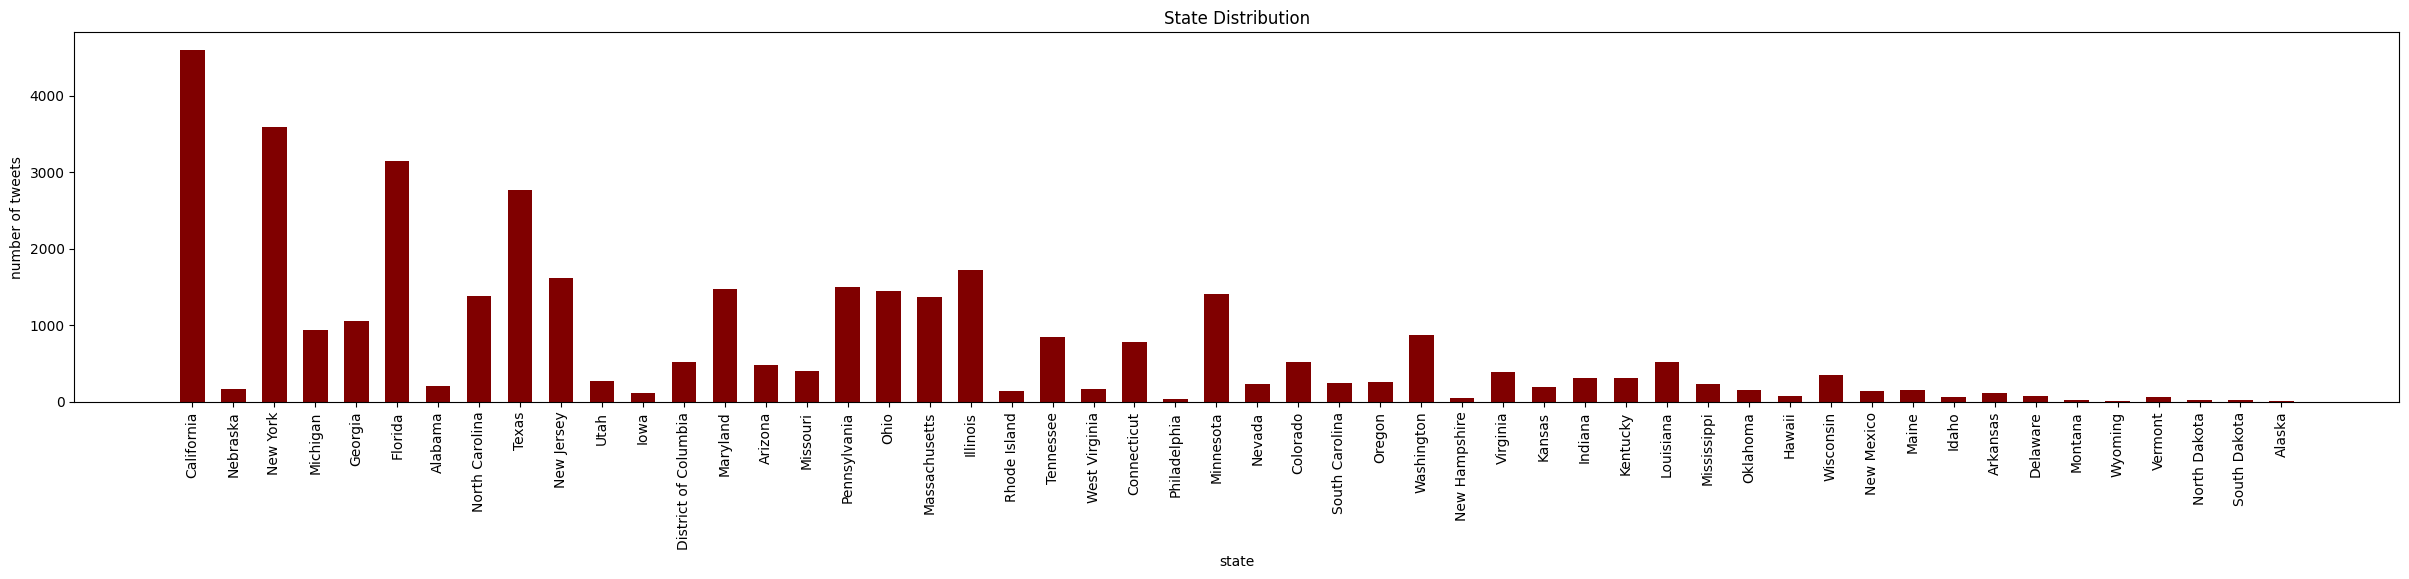

In [ ]:
locations = preds['state'].values

locations_dict = {}

for loc in locations:
  if loc in locations_dict:
    locations_dict[loc] += 1
  else:
    locations_dict[loc] = 1

locations_dict


locdict = pd.DataFrame()
locdict['loc'] = np.array(list(locations_dict.keys()))
locdict['freq'] = np.array(list(locations_dict.values()))

locdict.to_csv('/content/drive/My Drive/preproc_data/states_dict.csv')

plt.figure().set_figwidth(30)
plt.bar(locdict['loc'].values[1:], locdict['freq'].values[1:], color ='maroon',
        width = 0.6)
plt.xlabel("state")
plt.xticks(rotation='vertical')
plt.ylabel("number of tweets")
plt.title("State Distribution")
plt.show()

# TOPICS

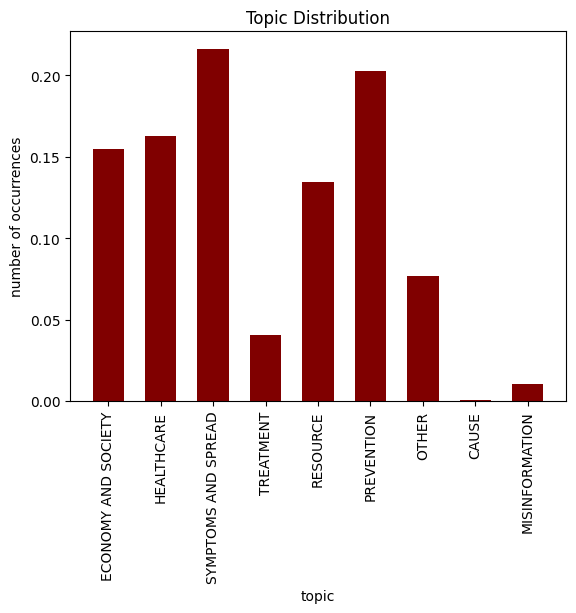

In [ ]:
topics = pred_topics
topics
topics_dict = {}

total_num = 0

for topiclist in topics:
  for topic in topiclist:
    total_num += 1
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

topics_dict
topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values())) / total_num

topdict.to_csv('/content/drive/My Drive/preproc_data/topdict.csv')

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("Topic Distribution")
plt.show()

In [ ]:
topdict

,loc,freq,prob
0,ECONOMY AND SOCIETY,295962,0.154812
1,HEALTHCARE,311517,0.162949
2,SYMPTOMS AND SPREAD,413367,0.216225
3,TREATMENT,77386,0.040479
4,RESOURCE,257509,0.134698
5,PREVENTION,387087,0.202478
6,OTHER,147314,0.077057
7,CAUSE,1249,0.000653
8,MISINFORMATION,20355,0.010647


# INTENTS

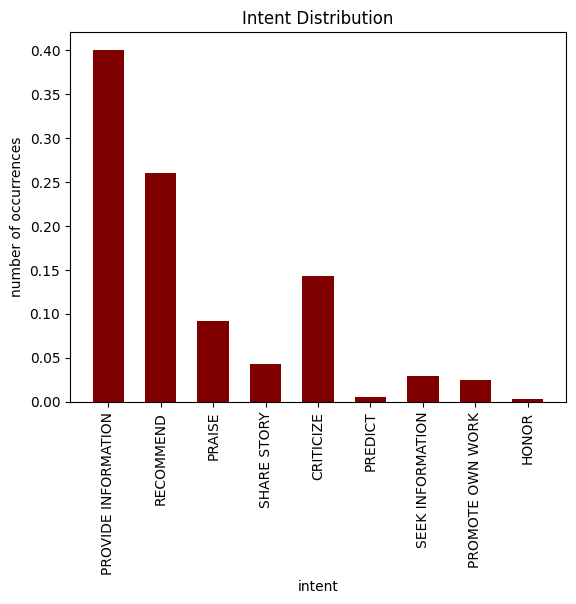

In [ ]:
intents = pred_intents

intents_dict = {}

total_num = 0

for intentlist in intents:
  for intent in intentlist:
    total_num += 1
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values())) / total_num
intdict.to_csv('/content/drive/My Drive/preproc_data/intdict.csv')

plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("Intent Distribution")
plt.show()

In [ ]:
intdict

,loc,freq,prob
0,PROVIDE INFORMATION,740619,0.400206
1,RECOMMEND,481167,0.260007
2,PRAISE,169387,0.091531
3,SHARE STORY,78772,0.042566
4,CRITICIZE,265266,0.143341
5,PREDICT,10135,0.005477
6,SEEK INFORMATION,54044,0.029204
7,PROMOTE OWN WORK,45097,0.024369
8,HONOR,6108,0.003301


# TIME

In [ ]:
years = preds['year'].values
months = preds['month'].values
days = preds['day'].values

dates = []

for year, month, day in zip(years,months,days):
  dates.append(str(year)+' '+str(month)+' '+str(day))

preds['date'] = np.array(dates)

In [ ]:
unique_days = list(preds['date'].unique())
len(unique_days)

572

In [ ]:
weeks = []

for year, month, day in zip(years,months,days):
  weekval = None
  if day > 0 and day < 8:
    weekval = 1
  if day >= 8 and day < 16:
    weekval = 2
  if day >= 15 and day < 23:
    weekval = 3
  if day >= 23:
    weekval = 4

  if year == 2020:
    weeks.append(month*4 + weekval)
  if year == 2021:
    weeks.append((month + 12)*4 + weekval)

preds['week'] = np.array(weeks)

In [ ]:
unique_weeks = preds['week'].unique()

week_dicts_list = list(np.zeros(83))

week_dicts = {}

week_tweets = list(np.zeros(83))

for weekval in unique_weeks:
  # print(weekval)
  preds_week = preds.loc[preds['week'] == weekval]
  week_tweets[weekval - 1] = preds_week.shape[0]
  spec_topics = preds_week['pred_topics'].values
  spec_intents = preds_week['pred_intents'].values

  for topiclist in spec_topics:
    for topic in topiclist:
      if topic in week_dicts:
        week_dicts[topic][weekval - 1] += 1
      else:
        week_dicts[topic] = week_dicts_list.copy()
        week_dicts[topic][weekval - 1] = 1

  for intentlist in spec_intents:
    for intent in intentlist:
      if intent in week_dicts:
        week_dicts[intent][weekval - 1] += 1
      else:
        week_dicts[intent] = week_dicts_list.copy()
        week_dicts[intent][weekval - 1] = 1


<ipython-input-20-2ea0a3be06b5>:8: RuntimeWarning: invalid value encountered in divide
  freqovertime = np.array(element[1])/np.array(week_tweets)


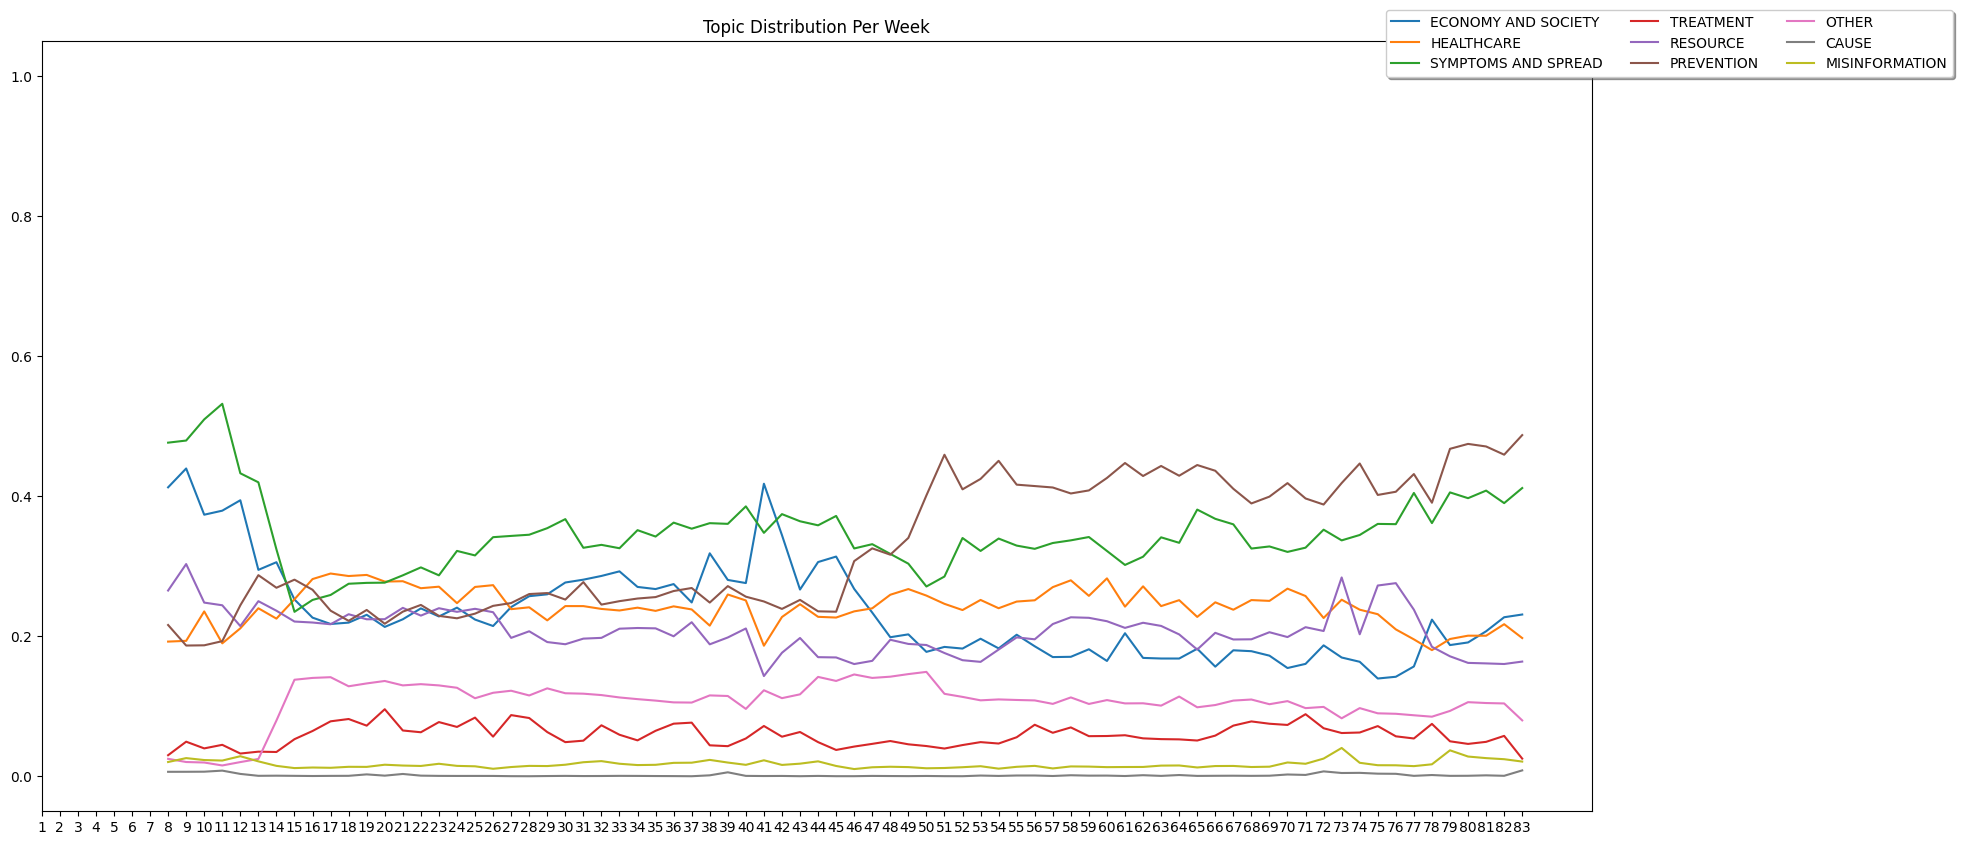

<ipython-input-20-2ea0a3be06b5>:22: RuntimeWarning: invalid value encountered in divide
  freqovertime = np.array(element[1])/np.array(week_tweets)


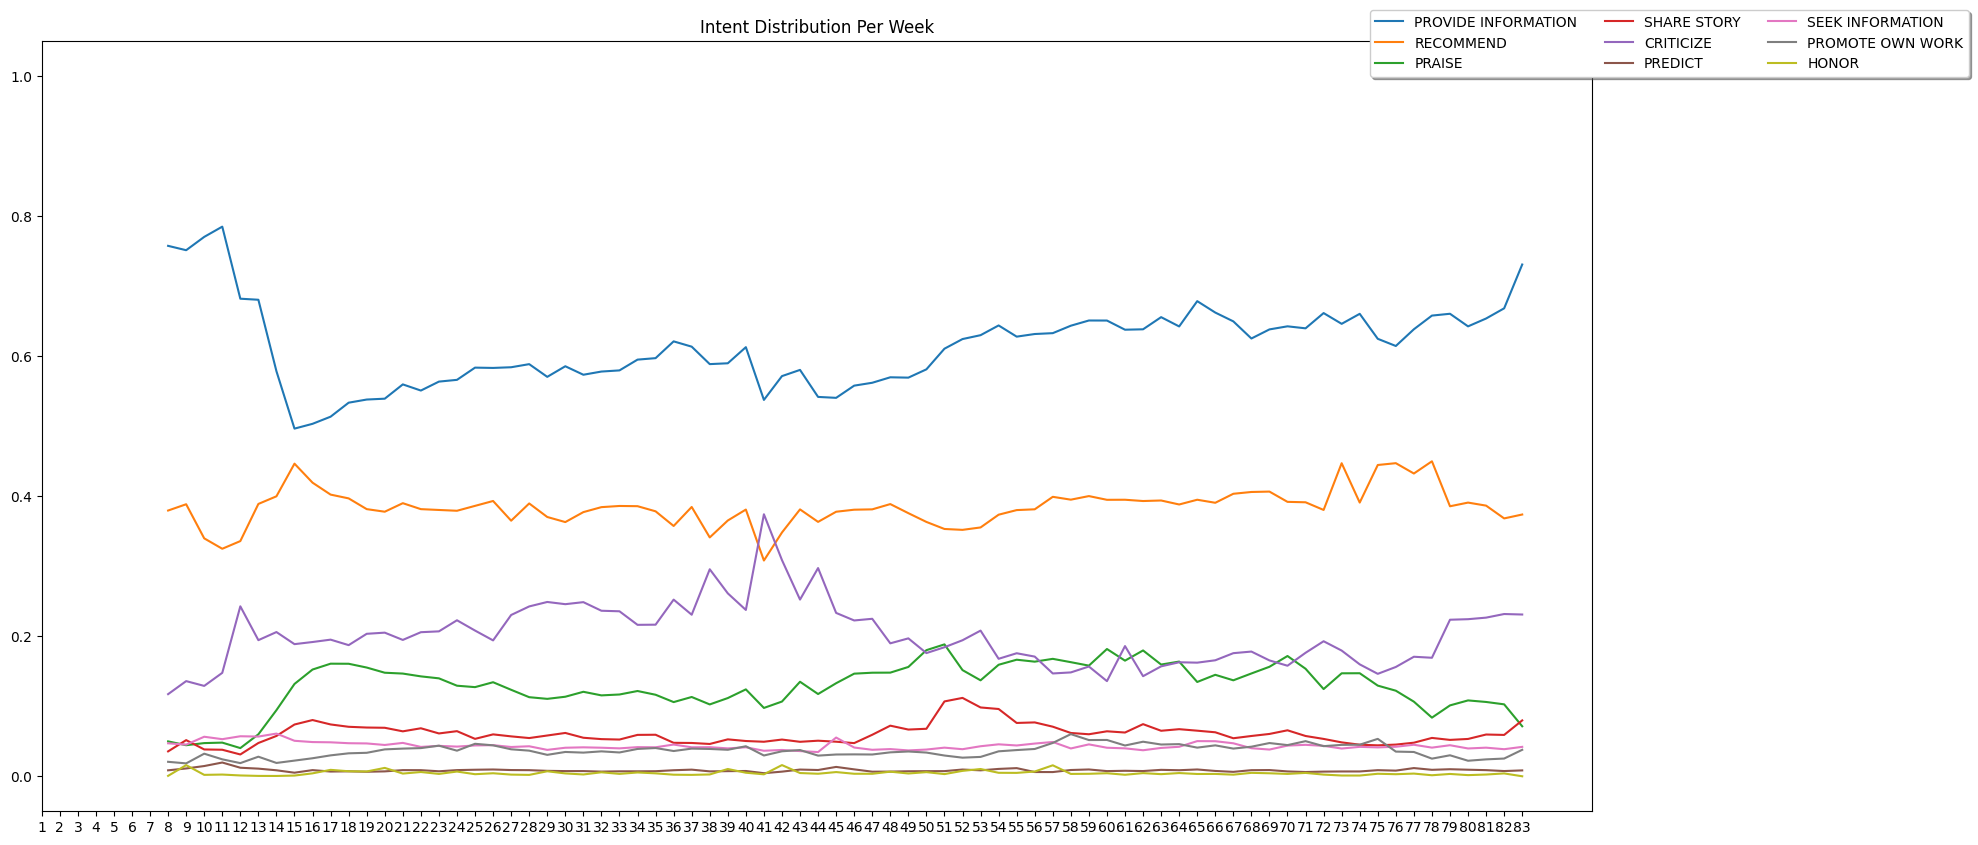

In [ ]:
week_vals = list(range(1, 84))

plt.figure(figsize=(20,10))
for i,element in enumerate(week_dicts.items()):
  label = element[0]

  if label in class_names[:9]:
    freqovertime = np.array(element[1])/np.array(week_tweets)
    plt.plot(week_vals, freqovertime, label = label)
    plt.xticks(week_vals)

plt.legend(loc='upper center', bbox_to_anchor=(1.05, 1.05),
            ncol=3, fancybox=True, shadow=True)
plt.title('Topic Distribution Per Week')
plt.show()

plt.figure(figsize=(20,10))
for i,element in enumerate(week_dicts.items()):
  label = element[0]

  if label in class_names[9:]:
    freqovertime = np.array(element[1])/np.array(week_tweets)
    plt.plot(week_vals, freqovertime, label = label)
    plt.xticks(week_vals)

plt.legend(loc='upper center', bbox_to_anchor=(1.05, 1.05),
            ncol=3, fancybox=True, shadow=True)
plt.title('Intent Distribution Per Week')
plt.show()

In [ ]:
time_dicts_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

time_dicts = {}

month_tweets = []

for year in [2020, 2021]:
  if year == 2020:
    preds2020 = preds.loc[preds['year'] == 2020]
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
      preds_month = preds2020.loc[preds['month'] == month]
      month_tweets.append(preds_month.shape[0])

      month2020 = month - 1

      spec_topics = preds_month['pred_topics'].values
      spec_intents = preds_month['pred_intents'].values

      for topiclist in spec_topics:
        for topic in topiclist:
          if topic in time_dicts:
            time_dicts[topic][month2020] += 1
          else:
            time_dicts[topic] = time_dicts_list.copy()
            time_dicts[topic][month2020] = 1

      for intentlist in spec_intents:
        for intent in intentlist:
          if intent in time_dicts:
            time_dicts[intent][month2020] += 1
          else:
            time_dicts[intent] = time_dicts_list.copy()
            time_dicts[intent][month2020] = 1
  if year == 2021:
    preds2021 = preds.loc[preds['year'] == 2021]
    for month in [1,2,3,4,5,6,7,8]:
      preds_month = preds2021.loc[preds['month'] == month]
      month_tweets.append(preds_month.shape[0])

      month2021 = month + 12 - 1

      spec_topics = preds_month['pred_topics'].values
      spec_intents = preds_month['pred_intents'].values

      for topiclist in spec_topics:
        for topic in topiclist:
          if topic in time_dicts:
            time_dicts[topic][month2021] += 1
          else:
            time_dicts[topic] = time_dicts_list.copy()
            time_dicts[topic][month2021] = 1

      for intentlist in spec_intents:
        for intent in intentlist:
          if intent in time_dicts:
            time_dicts[intent][month2021] += 1
          else:
            time_dicts[intent] = time_dicts_list.copy()
            time_dicts[intent][month2021] = 1


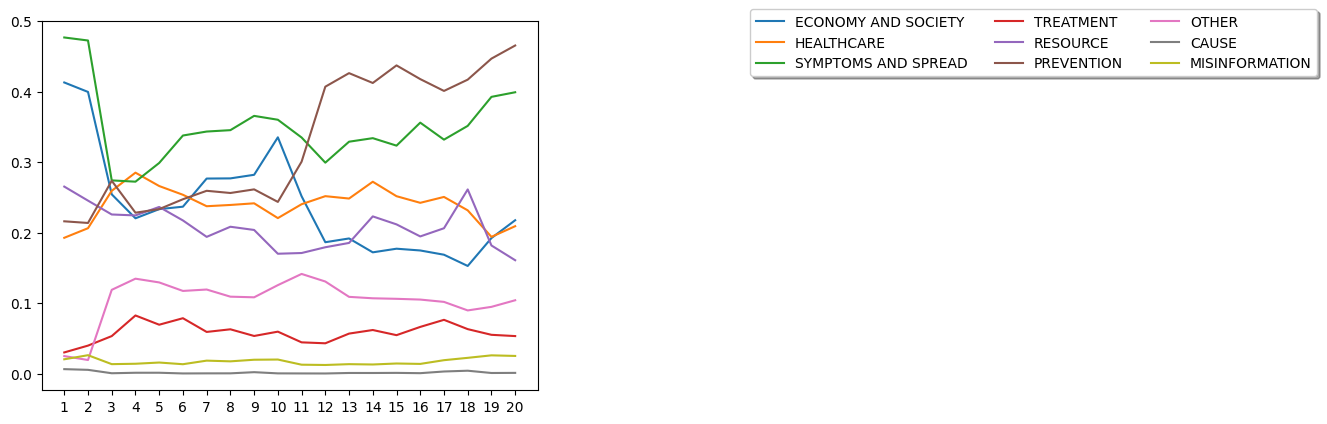

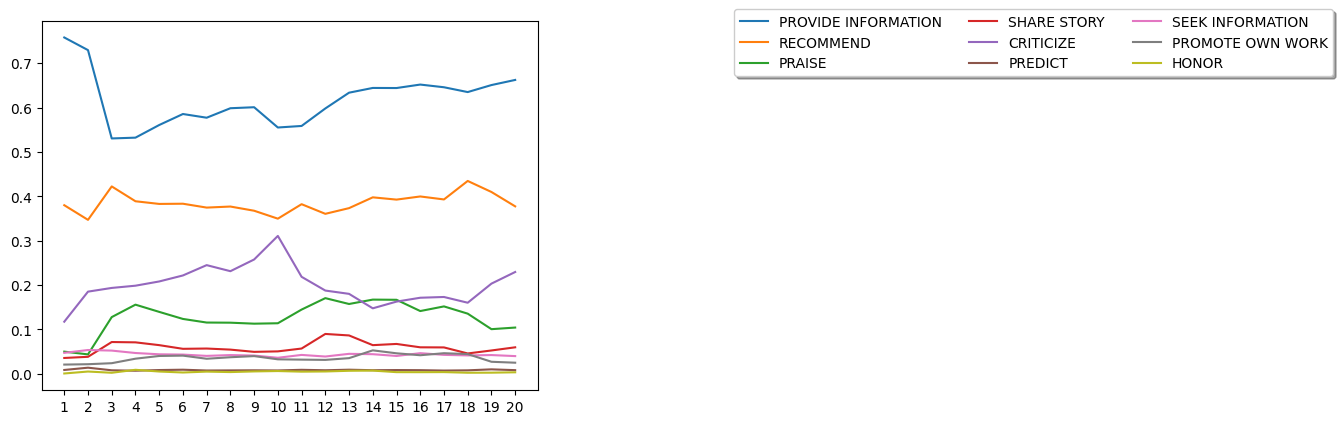

In [ ]:
months = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for i,element in enumerate(time_dicts.items()):
  if i <= 8:
    label = element[0]
    freqovertime = np.array(element[1])/np.array(month_tweets)
    # print(np.array(element[1]))
    # print(month_tweets[i])
    # print(freqovertime)
    plt.plot(months, freqovertime, label = label)
    plt.xticks(months)
  else:
    if i == 9:
      plt.legend(loc='upper center', bbox_to_anchor=(2, 1.05),
            ncol=3, fancybox=True, shadow=True)
      plt.show()
    label = element[0]
    freqovertime = np.array(element[1])/np.array(month_tweets)
    # print(np.array(element[1]))
    # print(month_tweets[i])
    # print(freqovertime)
    plt.plot(months, freqovertime, label = label)
    plt.xticks(months)

plt.legend(loc='upper center', bbox_to_anchor=(2, 1.05),
            ncol=3, fancybox=True, shadow=True)
plt.show()

# PROFESSION

## Running Profession Code

In [ ]:
professions = pd.read_csv('/content/drive/My Drive/preproc_data/professions/professions.csv', header=0)

ICU = professions['ICU'].values[:22]
ED = professions['ED'].values[:10]
PHYSICIAN = professions['PHYSICIAN'].values
NURSE = professions['NURSE'].values[:8]
TRAINEE = professions['TRAINEE'].values[:86]
NOTTRAINEE = professions['NOT TRAINEE'].values[:110]
NURSEDESC = NURSE[5:]

In [ ]:
ICU = [element.strip() for element in ICU]
ED = [element.strip() for element in ED]
PHYSICIAN = [element.strip() for element in PHYSICIAN]
NURSE = [element.strip() for element in NURSE]
TRAINEE = [element.strip() for element in TRAINEE]
NOTTRAINEE = [element.strip() for element in NOTTRAINEE]
NURSEDESC = [element.strip() for element in NURSEDESC]

In [ ]:
NURSEDESC

['nurse', 'nurse practitioner', 'nursepractitioner']

In [ ]:
import re

icu = []
ed = []
physician = []
nurse = []
trainee = []
nottrainee = []

usernames = preds['user_name'].values
userdesc = preds['user_description'].values

for name, desc in tqdm.tqdm(zip(usernames, userdesc)):

  is_icu = 0
  is_ed = 0
  is_phys = 0
  is_nurse = 0
  is_train = 0
  is_nottrain = 0

  # for element in ICU:
  #   if not pd.isnull(name):
  #     if element in name.lower():
  #       is_icu = 1
  #   if not pd.isnull(desc):
  #     if element in desc.lower():
  #       is_icu = 1

  # for element in ED:
  #   if not pd.isnull(name):
  #     if element in ['em doc', 'em physician', 'er doc', 'er physician']:
  #       match = re.search(r"\b" + re.escape(element) + r"\b", name.lower())
  #       if match:
  #         is_ed = 1
  #     else:
  #       if element in name.lower():
  #         is_ed = 1
  #   if not pd.isnull(desc):
  #     if element in ['em doc', 'em physician', 'er doc', 'er physician']:
  #       match = re.search(r"\b" + re.escape(element) + r"\b", name.lower())
  #       if match:
  #         is_ed = 1
  #     else:
  #       if element in desc.lower():
  #         is_ed = 1

  # for element in PHYSICIAN:
  #   if not pd.isnull(name):
  #     if element in ['em doc','em physician','er doc','er physician','ent doc','ent physician']:
  #       match = re.search(r"\b" + re.escape(element) + r"\b", name.lower())
  #       if match:
  #         is_phys = 1
  #     else:
  #       if element in name.lower():
  #         is_phys = 1
  #   if not pd.isnull(desc):
  #     if element in ['em doc','em physician','er doc','er physician','ent doc','ent physician']:
  #       match = re.search(r"\b" + re.escape(element) + r"\b", desc.lower())
  #       if match:
  #         is_phys = 1
  #     else:
  #       if element != 'md':
  #         if element in desc.lower():
  #           is_phys = 1

  # for element in NURSE:
  #   if not pd.isnull(name):
  #     match = re.search(r"\b" + re.escape(element) + r"\b", name.lower())
  #     if match:
  #       is_nurse = 1
  # for element in NURSEDESC:
  #   if not pd.isnull(desc):
  #     match = re.search(r"\b" + re.escape(element) + r"\b", desc.lower())
  #     if match:
  #       is_nurse = 1

  # for element in TRAINEE:
  #   if not pd.isnull(name):
  #     if element in name.lower():
  #       is_train = 1
  #   if not pd.isnull(desc):
  #     if element in desc.lower():
  #       is_train = 1

  # for element in NOTTRAINEE:
  #   if not pd.isnull(name):
  #     if element in ['em doc','em physician','er doc','er physician','ent doc','ent physician']:
  #       match = re.search(r"\b" + re.escape(element) + r"\b", name.lower())
  #       if match:
  #         is_nottrain = 1
  #     else:
  #       if element in name.lower():
  #         is_nottrain = 1
  #   if not pd.isnull(desc):
  #     if element in ['em doc','em physician','er doc','er physician','ent doc','ent physician']:
  #       match = re.search(r"\b" + re.escape(element) + r"\b", desc.lower())
  #       if match:
  #         is_nottrain = 1
  #     else:
  #       if element in desc.lower():
  #         is_nottrain = 1

  # new_isnurse = None
  # new_isphys = None
  # new_train = None
  # new_nottrain = None

  # if is_nurse == 1:
  #   new_isnurse = 1
  #   new_isphys = 0

  # if is_phys == 1:
  #   new_isnurse = 0
  #   new_isphys = 1

  # if is_train == 1:
  #   new_train = 1
  #   new_nottrain = 0

  # if is_nottrain == 1:
  #   new_train = 0
  #   new_nottrain = 1

  # icu.append(is_icu)
  # ed.append(is_ed)
  # physician.append(is_phys)
  # nurse.append(is_nurse)
  # trainee.append(is_train)
  # nottrainee.append(is_nottrain)

1255720it [10:24, 2009.91it/s]


In [ ]:
# preds['icu'] = np.array(icu)
# preds['ed'] = np.array(ed)
# preds['physician'] = np.array(physician)
# preds['nurse'] = np.array(nurse)
# preds['trainee'] = np.array(trainee)
# preds['not trainee'] = np.array(nottrainee)

# preds.to_csv('/content/drive/My Drive/preproc_data/preds_all.csv')

## Getting PREDS with Professions Added

In [ ]:
preds = pd.read_csv('/content/drive/My Drive/preproc_data/PREDS/preds_all.csv', header=0)
preds['pred_topics'] = pred_topics_array
preds['pred_intents'] = pred_intents_array

In [ ]:
preds.loc[preds['HONOR'] == 1, ['tweet', 'pred_intents']].sample(15).values

In [ ]:
# nonphys = []
# for i, e, phys in zip(preds['icu'].values, preds['ed'].values, preds['physician'].values):
#   if i == 0 and e == 0 and phys == 1:
#     nonphys.append(1)
#   else:
#     nonphys.append(0)

# preds['non-icu, non-ed physician'] = np.array(nonphys)

In [ ]:
preds.loc[(preds['nurse'] == 1) & (preds['physician'] == 1), ['user_name', 'user_description']]

,user_name,user_description
253,James N,"Physician, Registered Nurse, Scientist and a p..."
748,First Choice Neurology,First Choice Neurology is a group of Florida N...
800,Ertha Lugod,"Long suffering wife of a surgeon, sleep depriv..."
2164,First Choice Neurology,First Choice Neurology is a group of Florida N...
2216,First Choice Neurology,First Choice Neurology is a group of Florida N...
...,...,...
1247192,MedTalk,The ppl’s voice #healthcare #surgical #robotic...
1252808,"Rachel Knutson RN, BAN, MSCN",Novartis Sr Sales Specialist. Account intended...
1253217,NeoMaxiZoomDweebie,"Movie lover, gif and meme connoisseur, Medicar..."
1253484,Arun Swaminath MD & Isabel Roitman NP,Team of IBD specialists at the Lenox Hill Hosp...


In [ ]:
sums = pd.DataFrame(preds[['icu', 'ed', 'physician', 'nurse', 'trainee', 'not trainee']].sum(), columns=['number'])
sums

,number
icu,4880
ed,9672
physician,926836
nurse,315979
trainee,15678
not trainee,700109


In [ ]:
icu = preds['icu'].values
ed = preds['ed'].values
physician = preds['physician'].values
nurse = preds['nurse'].values
trainee = preds['trainee'].values
nottrainee = preds['not trainee'].values

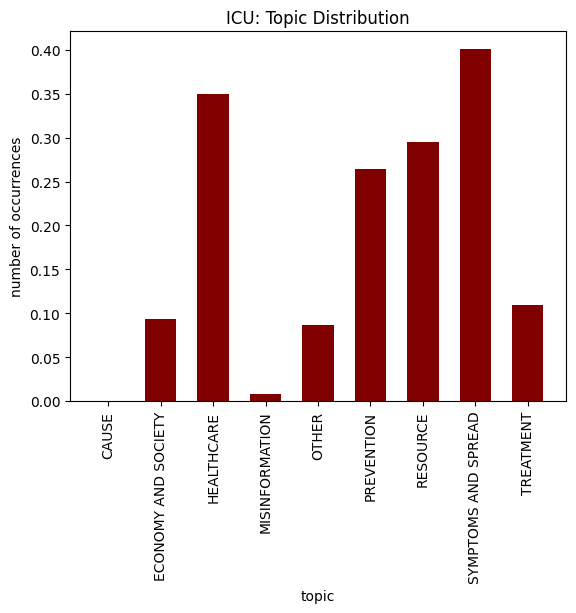

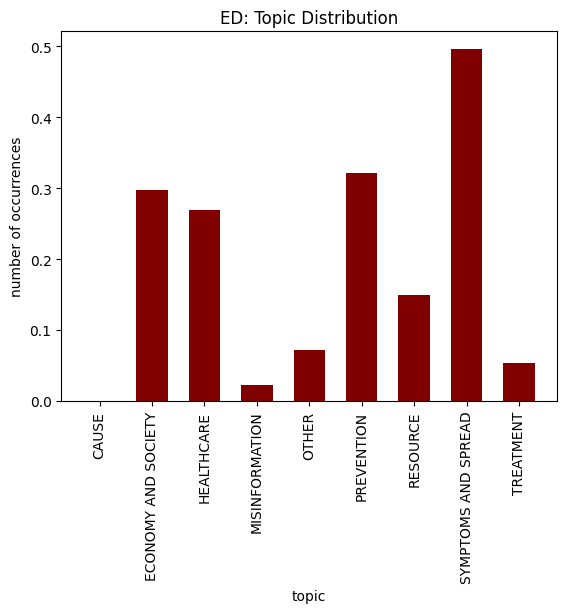

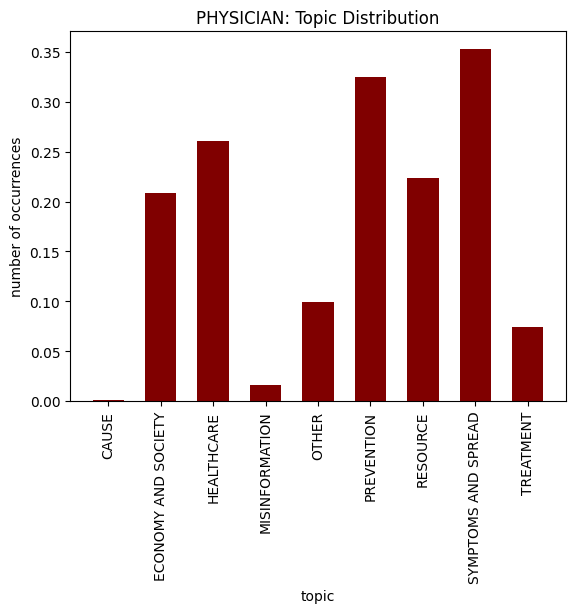

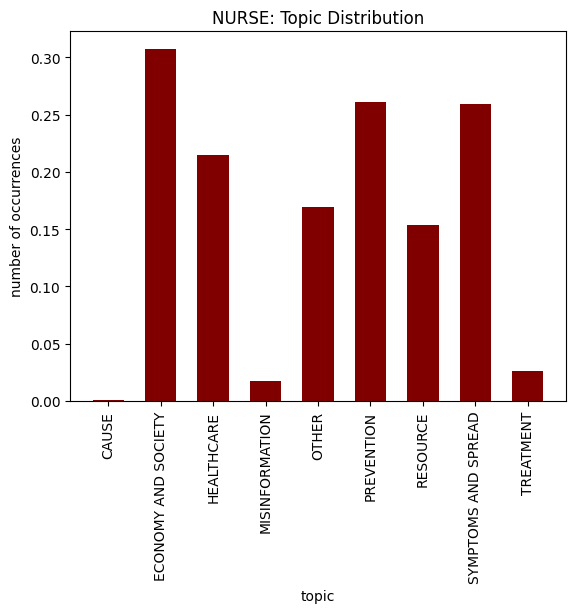

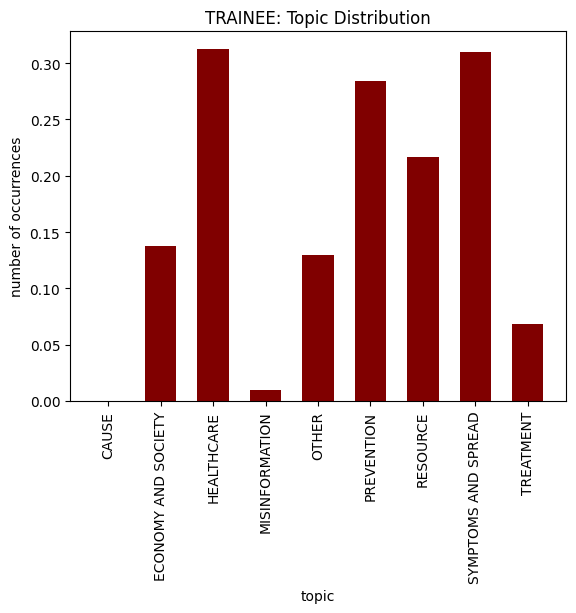

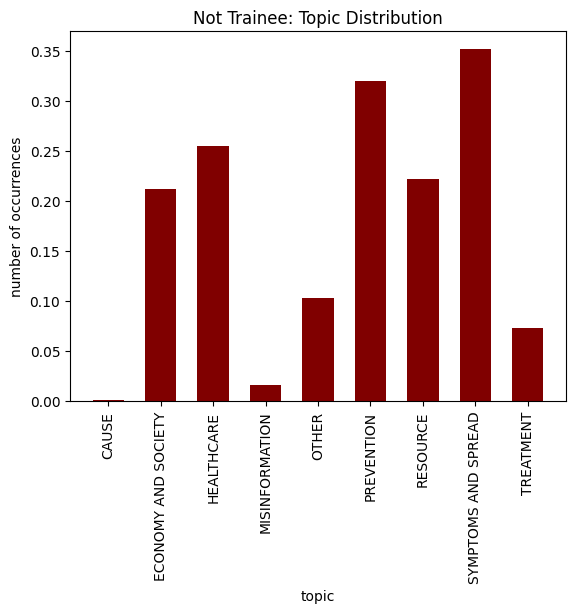

In [ ]:
predsICU = preds.loc[preds['icu'] == 1]
topics = predsICU['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}

topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values()))/predsICU.shape[0]
icu_topics = np.array(list(topics_dict.values()))/predsICU.shape[0]
topdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/icutopdict.csv')

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("ICU: Topic Distribution")
plt.show()

# ------------------

predsED = preds.loc[preds['ed'] == 1]
topics = predsED['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}

topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values()))/predsED.shape[0]
ed_topics = np.array(list(topics_dict.values()))/predsED.shape[0]
topdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/edtopdict.csv')

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("ED: Topic Distribution")
plt.show()

# -----------------

predsphys = preds.loc[preds['physician'] == 1]
topics = predsphys['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}

topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values()))/predsphys.shape[0]
phys_topics = np.array(list(topics_dict.values()))/predsphys.shape[0]
topdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/phystopdict.csv')

# NON PHYS ------------------

preds_nonphys = preds.loc[preds['non-icu, non-ed physician'] == 1]
topics = preds_nonphys['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}
nonphys_topics = np.array(list(topics_dict.values()))/preds_nonphys.shape[0]

# -------------------------

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("PHYSICIAN: Topic Distribution")
plt.show()

# ----------

predsnurse = preds.loc[preds['nurse'] == 1]
topics = predsnurse['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}

topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values()))/predsnurse.shape[0]
nurse_topics = np.array(list(topics_dict.values()))/predsnurse.shape[0]
topdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/nursetopdict.csv')

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("NURSE: Topic Distribution")
plt.show()

# --------------

predstrainee = preds.loc[preds['trainee'] == 1]
topics = predstrainee['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}

topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values()))/predstrainee.shape[0]
trainee_topics = np.array(list(topics_dict.values()))/predstrainee.shape[0]
topdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/traineetopdict.csv')

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("TRAINEE: Topic Distribution")
plt.show()

# ------------------

predsnottrainee = preds.loc[preds['not trainee'] == 1]
topics = predsnottrainee['pred_topics'].values

topics_dict = {}

for topiclist in topics:
  for topic in topiclist:
    if topic in topics_dict:
      topics_dict[topic] += 1
    else:
      topics_dict[topic] = 1

myKeys = list(topics_dict.keys())
myKeys.sort()
topics_dict = {i: topics_dict[i] for i in myKeys}

topdict = pd.DataFrame()
topdict['loc'] = np.array(list(topics_dict.keys()))
topdict['freq'] = np.array(list(topics_dict.values()))
topdict['prob'] = np.array(list(topics_dict.values()))/predsnottrainee.shape[0]
nottraineetopics = np.array(list(topics_dict.values()))/predsnottrainee.shape[0]
topdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/nottraineetopdict.csv')

plt.figure()
plt.bar(topdict['loc'].values, topdict['prob'].values, color ='maroon',
        width = 0.6)
plt.xlabel("topic")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("Not Trainee: Topic Distribution")
plt.show()

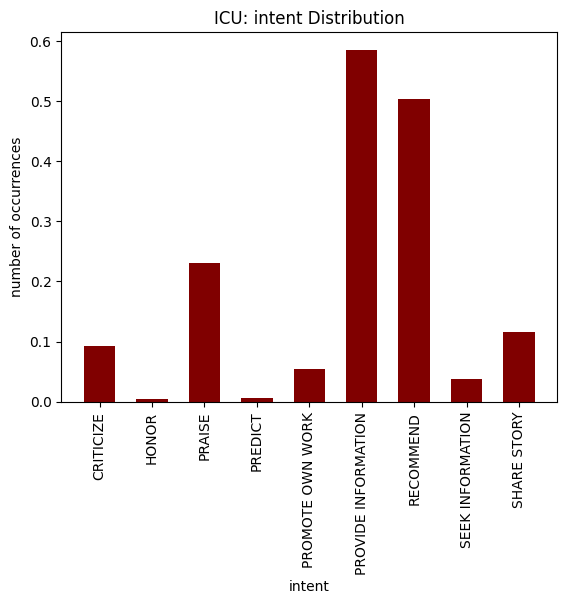

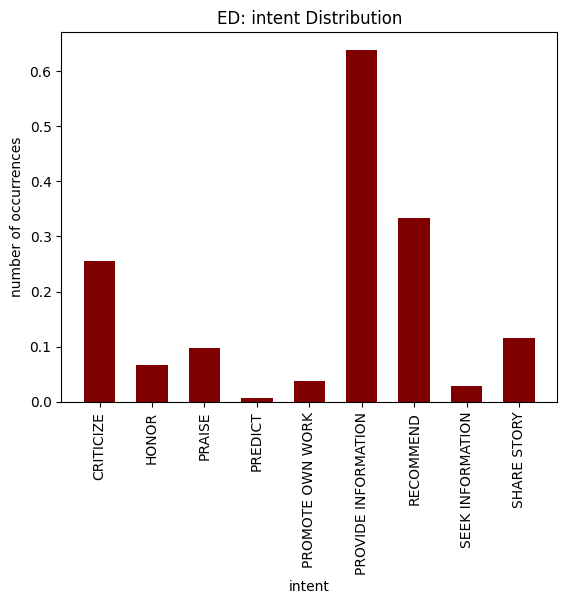

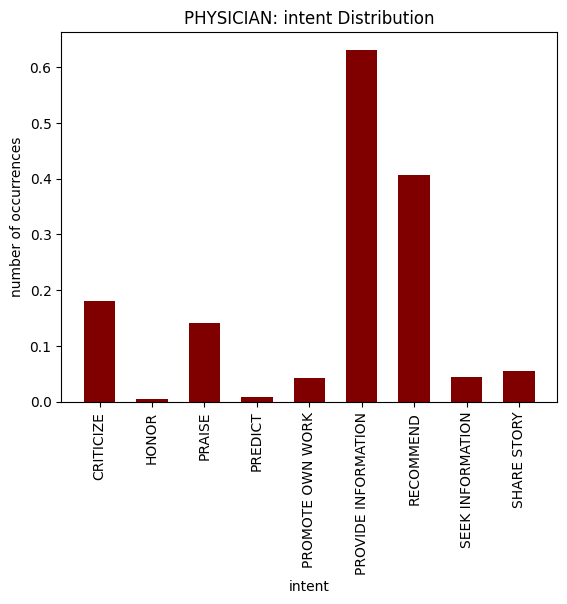

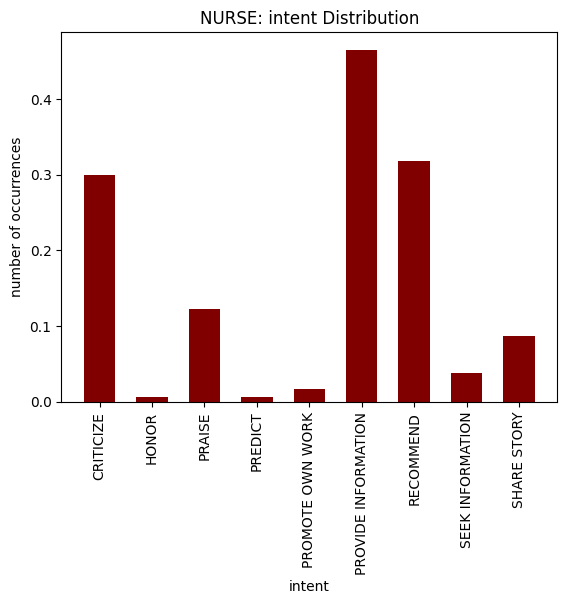

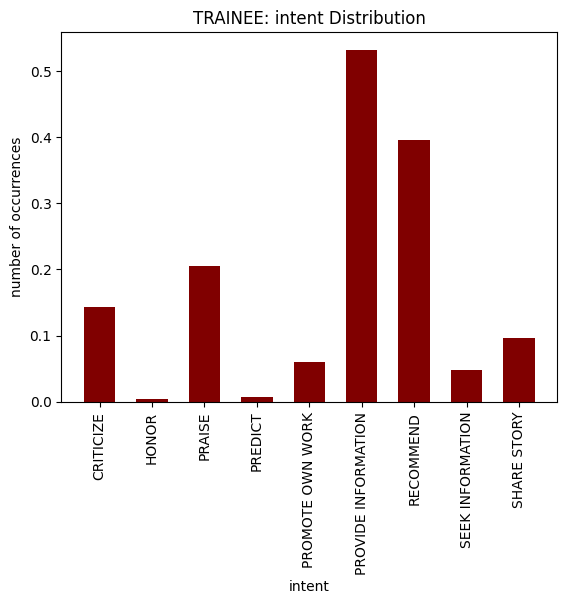

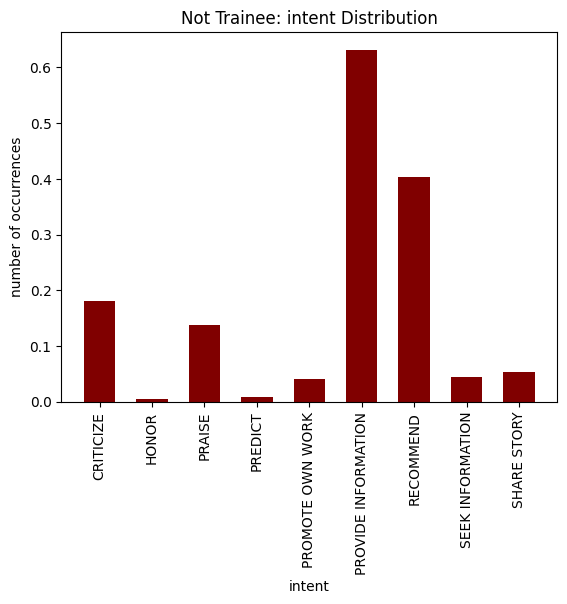

In [ ]:
predsICU = preds.loc[preds['icu'] == 1]
intents = predsICU['pred_intents'].values


intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values()))/predsICU.shape[0]
icu_intents = np.array(list(intents_dict.values()))/predsICU.shape[0]

intdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/icuintdict.csv')


plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("ICU: intent Distribution")
plt.show()


# ------------------


predsED = preds.loc[preds['ed'] == 1]
intents = predsED['pred_intents'].values


intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values()))/predsED.shape[0]
ed_intents = np.array(list(intents_dict.values()))/predsED.shape[0]
intdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/edintdict.csv')


plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("ED: intent Distribution")
plt.show()


# -----------------


predsphys = preds.loc[preds['physician'] == 1]
preds_nonphys = preds.loc[preds['non-icu, non-ed physician'] == 1]
intents = predsphys['pred_intents'].values


intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values()))/predsphys.shape[0]
phys_intents = np.array(list(intents_dict.values()))/predsphys.shape[0]
intdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/physintdict.csv')

# NON PHYS ------------------

preds_nonphys = preds.loc[preds['non-icu, non-ed physician'] == 1]
intents = preds_nonphys['pred_intents'].values

intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1

myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}
nonphys_intents = np.array(list(intents_dict.values()))/preds_nonphys.shape[0]

# -------------------------


plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("PHYSICIAN: intent Distribution")
plt.show()


# ----------


predsnurse = preds.loc[preds['nurse'] == 1]
intents = predsnurse['pred_intents'].values


intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values()))/predsnurse.shape[0]
nurse_intents = np.array(list(intents_dict.values()))/predsnurse.shape[0]
intdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/nurseintdict.csv')


plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("NURSE: intent Distribution")
plt.show()


# --------------


predstrainee = preds.loc[preds['trainee'] == 1]
intents = predstrainee['pred_intents'].values


intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values()))/predstrainee.shape[0]
trainee_intents = np.array(list(intents_dict.values()))/predstrainee.shape[0]
intdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/traineeintdict.csv')


plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("TRAINEE: intent Distribution")
plt.show()


# ------------------


predsnottrainee = preds.loc[preds['not trainee'] == 1]
intents = predsnottrainee['pred_intents'].values


intents_dict = {}


for intentlist in intents:
  for intent in intentlist:
    if intent in intents_dict:
      intents_dict[intent] += 1
    else:
      intents_dict[intent] = 1


myKeys = list(intents_dict.keys())
myKeys.sort()
intents_dict = {i: intents_dict[i] for i in myKeys}


intdict = pd.DataFrame()
intdict['loc'] = np.array(list(intents_dict.keys()))
intdict['freq'] = np.array(list(intents_dict.values()))
intdict['prob'] = np.array(list(intents_dict.values()))/predsnottrainee.shape[0]
nottrainee_intents = np.array(list(intents_dict.values()))/predsnottrainee.shape[0]
intdict.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/nottraineeintdict.csv')


plt.figure()
plt.bar(intdict['loc'].values, intdict['prob'].values, color ='maroon',
width = 0.6)
plt.xlabel("intent")
plt.xticks(rotation='vertical')
plt.ylabel("number of occurrences")
plt.title("Not Trainee: intent Distribution")
plt.show()


## Profession Comparison Graphs

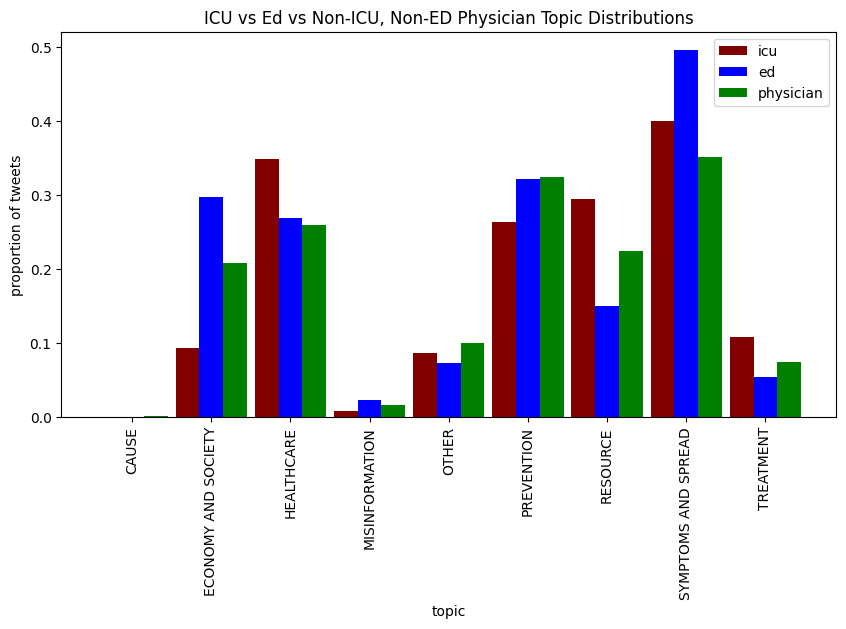

In [ ]:
# ICU vs ED vs OTHER

fig, ax = plt.subplots()
icu_plot = ax.bar(range(9), icu_topics, color ='maroon',
width = 0.3, label='icu')
ed_plot = ax.bar(np.array(range(9))+0.3, ed_topics, color ='blue',
width = 0.3, label='ed')
phys_plot = ax.bar(np.array(range(9))+0.3+0.3, nonphys_topics, color ='green',
width = 0.3, label='physician')

icuVSedVSother = pd.DataFrame()
icuVSedVSother['icu_prob'] = icu_topics
icuVSedVSother['ed_prob'] = ed_topics
icuVSedVSother['nonicu noned physician_prob'] = nonphys_topics
icuVSedVSother.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/ICUvsEDvsPHYSICIAN_topics.csv')

ax.set_xlabel('topic')
ax.set_ylabel('proportion of tweets')
ax.set_title('ICU vs Ed vs Non-ICU, Non-ED Physician Topic Distributions')
ax.set_xticks(np.array(range(9)) + 0.3)
ax.set_xticklabels(topdict['loc'].values, rotation='vertical')
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

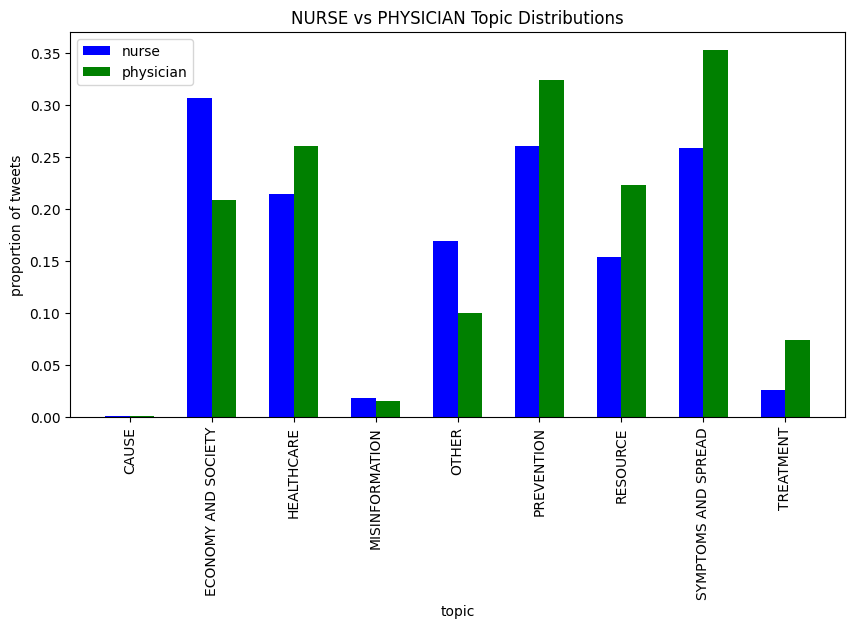

In [ ]:
# NURSE vs PHYSICIAN

fig, ax = plt.subplots()
nurse_plot = ax.bar(range(9), nurse_topics, color ='blue',
width = 0.3, label='nurse')
phys_plot = ax.bar(np.array(range(9))+0.3, phys_topics, color ='green',
width = 0.3, label='physician')

nurseVSphys = pd.DataFrame()
nurseVSphys['nurse_prob'] = nurse_topics
nurseVSphys['phys_prob'] = phys_topics
nurseVSphys.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/NURSEvsPHYSICIAN_topics.csv')

ax.set_xlabel('topic')
ax.set_ylabel('proportion of tweets')
ax.set_title('NURSE vs PHYSICIAN Topic Distributions')
ax.set_xticks(np.array(range(9)) + 0.3/2)
ax.set_xticklabels(topdict['loc'].values, rotation='vertical')
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

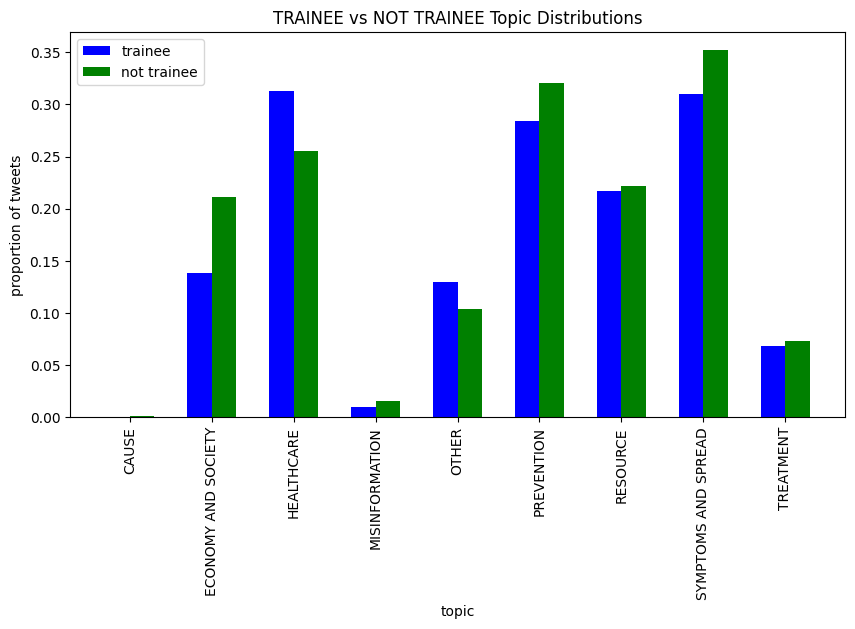

In [ ]:
# TRAINEE vs NOT TRAINEE

fig, ax = plt.subplots()
trainee_plot = ax.bar(range(9), trainee_topics, color ='blue',
width = 0.3, label='trainee')
nottrainee_plot = ax.bar(np.array(range(9))+0.3, nottraineetopics, color ='green',
width = 0.3, label='not trainee')

trainVSnot = pd.DataFrame()
trainVSnot['trainee_prob'] = trainee_topics
trainVSnot['nottrainee_prob'] = nottraineetopics
trainVSnot.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/TRAINEEvsNOTTRAINEE_topics.csv')

ax.set_xlabel('topic')
ax.set_ylabel('proportion of tweets')
ax.set_title('TRAINEE vs NOT TRAINEE Topic Distributions')
ax.set_xticks(np.array(range(9)) + 0.3/2)
ax.set_xticklabels(topdict['loc'].values, rotation='vertical')
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

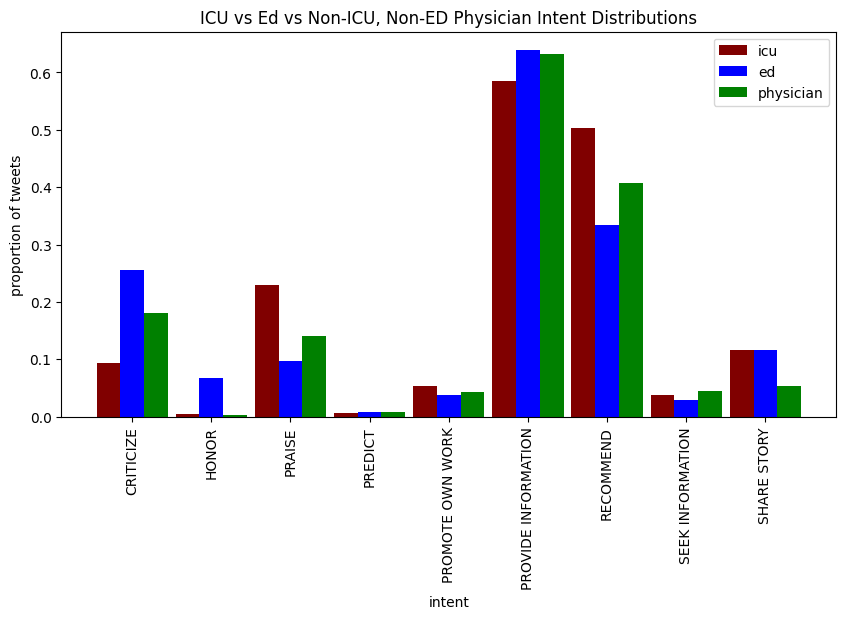

In [ ]:
# ICU vs ED vs OTHER

fig, ax = plt.subplots()
icu_plot = ax.bar(range(9), icu_intents, color ='maroon',
width = 0.3, label='icu')
ed_plot = ax.bar(np.array(range(9))+0.3, ed_intents, color ='blue',
width = 0.3, label='ed')
phys_plot = ax.bar(np.array(range(9))+0.3+0.3, nonphys_intents, color ='green',
width = 0.3, label='physician')

icuVSedVSother = pd.DataFrame()
icuVSedVSother['icu_prob'] = icu_intents
icuVSedVSother['ed_prob'] = ed_intents
icuVSedVSother['nonicu noned physician_prob'] = nonphys_intents
icuVSedVSother.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/ICUvsEDvsPHYSICIAN_intents.csv')

ax.set_xlabel('intent')
ax.set_ylabel('proportion of tweets')
ax.set_title('ICU vs Ed vs Non-ICU, Non-ED Physician Intent Distributions')
ax.set_xticks(np.array(range(9)) + 0.3)
ax.set_xticklabels(intdict['loc'].values, rotation='vertical')
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

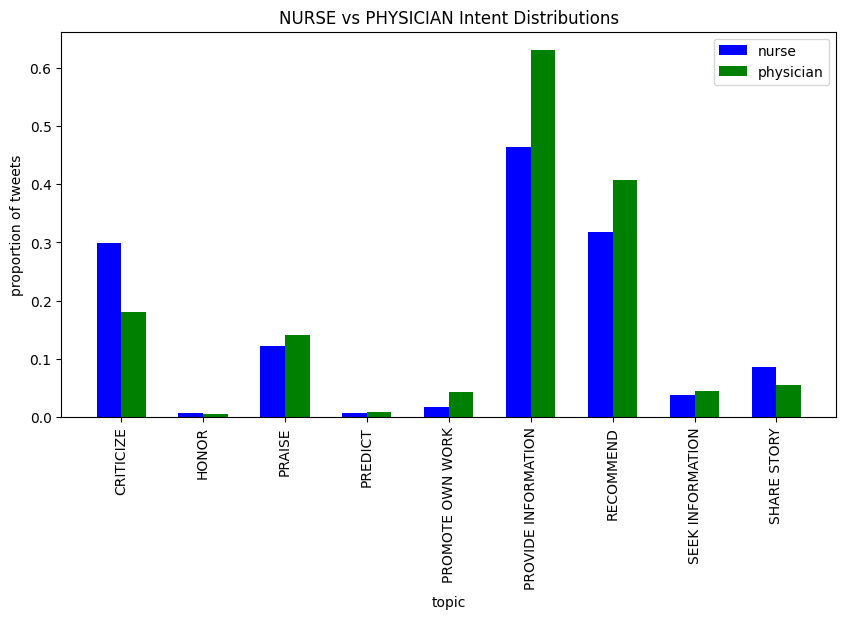

In [ ]:
# NURSE vs PHYSICIAN

fig, ax = plt.subplots()
nurse_plot = ax.bar(range(9), nurse_intents, color ='blue',
width = 0.3, label='nurse')
phys_plot = ax.bar(np.array(range(9))+0.3, phys_intents, color ='green',
width = 0.3, label='physician')

nurseVSphys = pd.DataFrame()
nurseVSphys['nurse_prob'] = nurse_intents
nurseVSphys['phys_prob'] = phys_intents
nurseVSphys.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/NURSEvsPHYSICIAN_intents.csv')

ax.set_xlabel('topic')
ax.set_ylabel('proportion of tweets')
ax.set_title('NURSE vs PHYSICIAN Intent Distributions')
ax.set_xticks(np.array(range(9)) + 0.3/2)
ax.set_xticklabels(intdict['loc'].values, rotation='vertical')
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

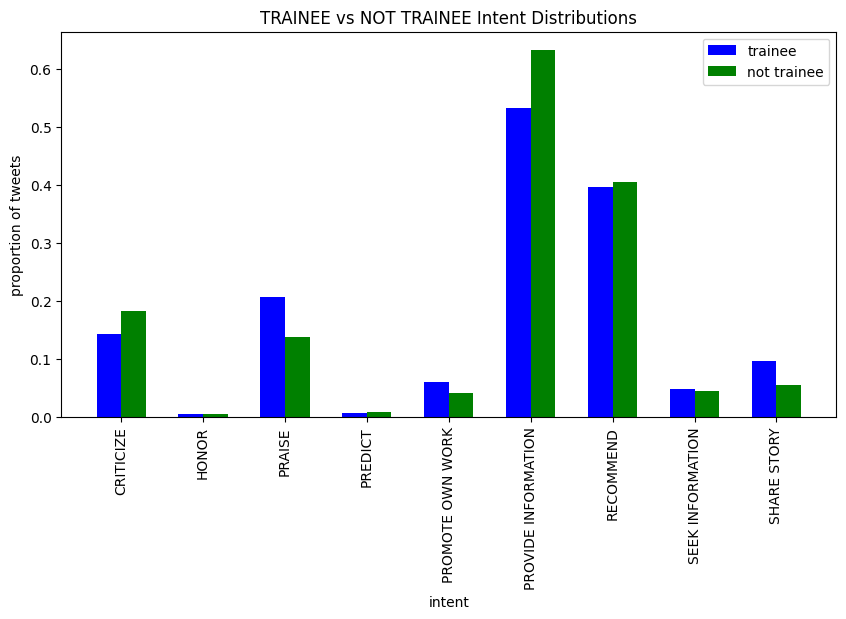

In [ ]:
# TRAINEE vs NOT TRAINEE

fig, ax = plt.subplots()
trainee_plot = ax.bar(range(9), trainee_intents, color ='blue',
width = 0.3, label='trainee')
nottrainee_plot = ax.bar(np.array(range(9))+0.3, nottrainee_intents, color ='green',
width = 0.3, label='not trainee')

trainVSnot = pd.DataFrame()
trainVSnot['trainee_prob'] = trainee_intents
trainVSnot['nottrainee_prob'] = nottrainee_intents
trainVSnot.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/TRAINEEvsNOTTRAINEE_intents.csv')

ax.set_xlabel('intent')
ax.set_ylabel('proportion of tweets')
ax.set_title('TRAINEE vs NOT TRAINEE Intent Distributions')
ax.set_xticks(np.array(range(9)) + 0.3/2)
ax.set_xticklabels(intdict['loc'].values, rotation='vertical')
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

# TOPIC INTENT CORRELATION

<Axes: >

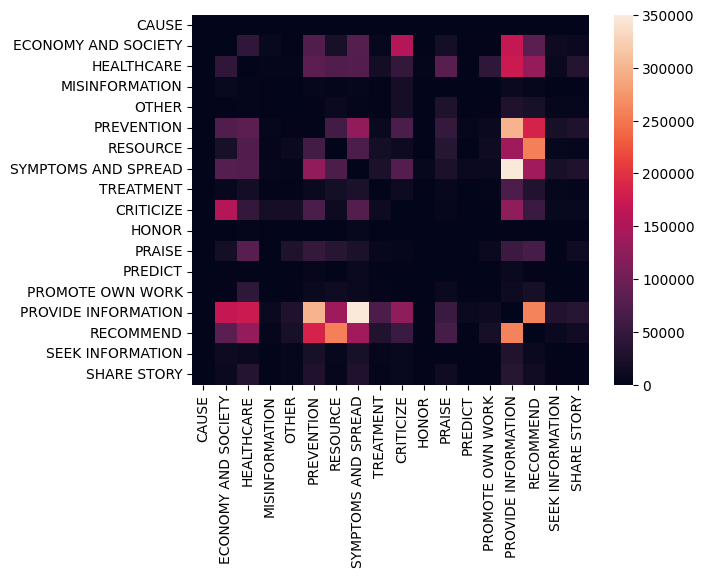

In [ ]:
from itertools import combinations
import seaborn as sns

topics = preds['pred_topics'].values
intents = preds['pred_intents'].values
total = topics + intents

class2id = {val:key for key, val in classes.items()}
corrmap = np.zeros((18,18))

for totallist in total:
  combs = combinations(totallist, 2)
  for element in combs:
    id1 = class2id[element[0]]
    id2 = class2id[element[1]]

    corrmap[id1][id2] += 1
    corrmap[id2][id1] += 1

sns.heatmap(corrmap, xticklabels=list(class2id.keys()), yticklabels=list(class2id.keys()), vmin=0, vmax=350000)

In [ ]:
class2id

{'CAUSE': 0,
 'ECONOMY AND SOCIETY': 1,
 'HEALTHCARE': 2,
 'MISINFORMATION': 3,
 'OTHER': 4,
 'PREVENTION': 5,
 'RESOURCE': 6,
 'SYMPTOMS AND SPREAD': 7,
 'TREATMENT': 8,
 'CRITICIZE': 9,
 'HONOR': 10,
 'PRAISE': 11,
 'PREDICT': 12,
 'PROMOTE OWN WORK': 13,
 'PROVIDE INFORMATION': 14,
 'RECOMMEND': 15,
 'SEEK INFORMATION': 16,
 'SHARE STORY': 17}

Text(50.7222222222222, 0.5, 'Topics')

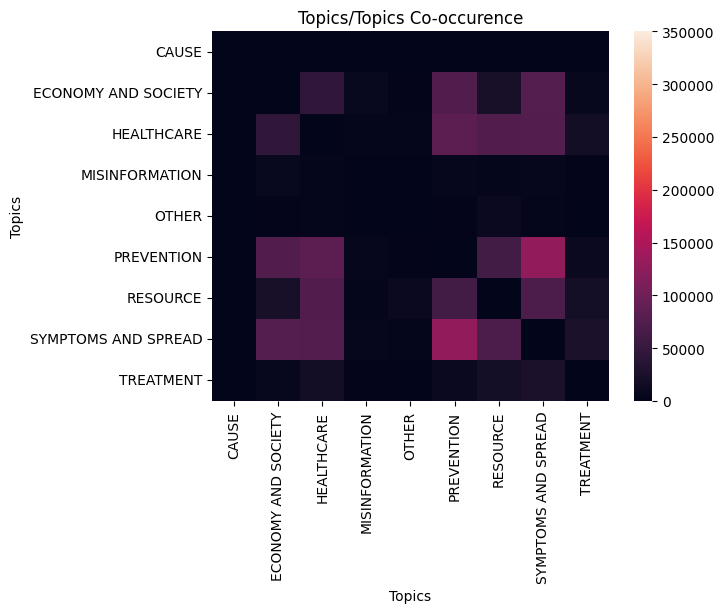

In [ ]:
sns.heatmap(corrmap[:9, :9], xticklabels=list(class2id.keys())[:9], yticklabels=list(class2id.keys())[:9], vmin=0, vmax = 350000)
plt.title('Topics/Topics Co-occurence')
plt.xlabel('Topics')
plt.ylabel('Topics')

Text(50.7222222222222, 0.5, 'Intents')

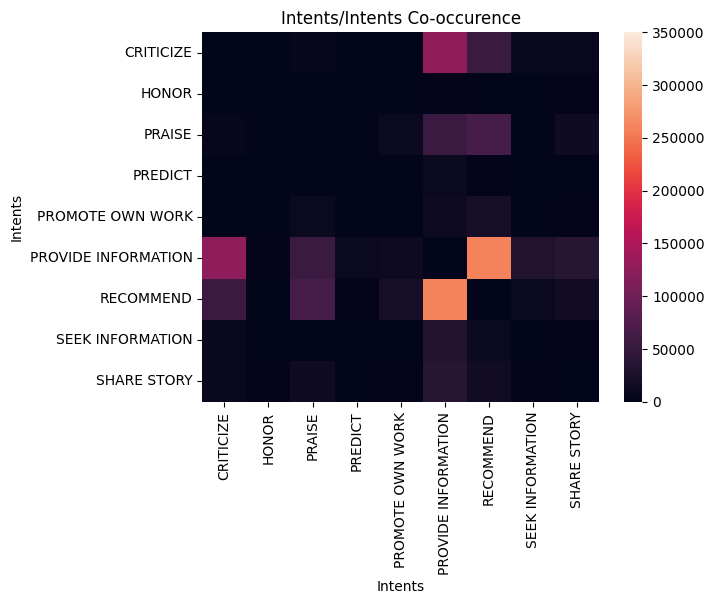

In [ ]:
sns.heatmap(corrmap[9:,9:], xticklabels=list(class2id.keys())[9:], yticklabels=list(class2id.keys())[9:], vmin=0, vmax = 350000)
plt.title('Intents/Intents Co-occurence')
plt.xlabel('Intents')
plt.ylabel('Intents')

Text(50.7222222222222, 0.5, 'Topics')

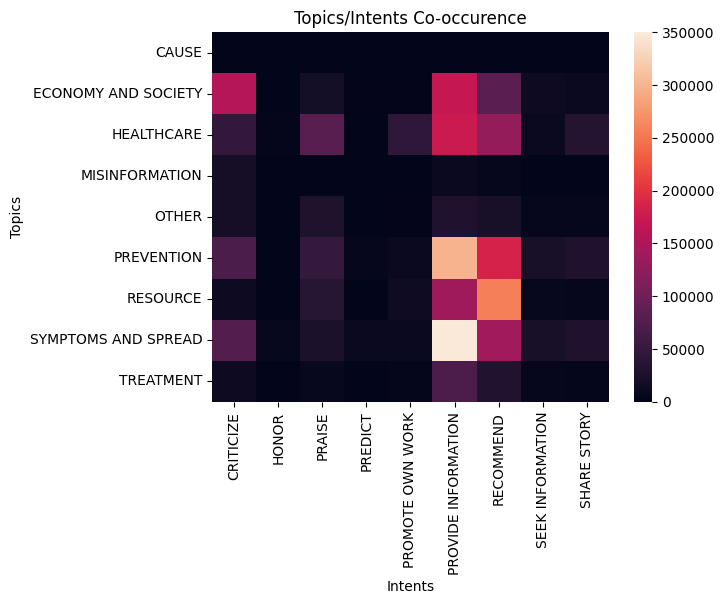

In [ ]:
ax = sns.heatmap(corrmap[:9, 9:], xticklabels=list(class2id.keys())[9:], yticklabels=list(class2id.keys())[:9], vmin=0, vmax=350000.0)
plt.title('Topics/Intents Co-occurence')
plt.xlabel('Intents')
plt.ylabel('Topics')

In [ ]:
correlation_map

,CRITICIZE,HONOR,PRAISE,PREDICT,PROMOTE OWN WORK,PROVIDE INFORMATION,RECOMMEND,SEEK INFORMATION,SHARE STORY
CAUSE,930.0,155554.0,46656.0,20282.0,19704.0,70292.0,12512.0,76623.0,11483.0
ECONOMY AND SOCIETY,155554.0,1232.0,22769.0,1666.0,2670.0,170330.0,82242.0,17353.0,9817.0
HEALTHCARE,46656.0,22769.0,162722.0,2047.0,70688.0,222309.0,166735.0,34820.0,39007.0
MISINFORMATION,20282.0,1666.0,2047.0,132.0,528.0,14294.0,5749.0,10466.0,359.0
OTHER,19704.0,2670.0,70688.0,528.0,3146.0,39291.0,35636.0,12925.0,7776.0
PREVENTION,70292.0,170330.0,222309.0,14294.0,39291.0,596966.0,323842.0,369871.0,100006.0
RESOURCE,12512.0,82242.0,166735.0,5749.0,35636.0,323842.0,511610.0,146304.0,36381.0
SYMPTOMS AND SPREAD,76623.0,17353.0,34820.0,10466.0,12925.0,369871.0,146304.0,43824.0,34783.0
TREATMENT,11483.0,9817.0,39007.0,359.0,7776.0,100006.0,36381.0,34783.0,6978.0


In [ ]:
c = np.zeros((9,9))

In [ ]:
c[3:, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
c[0][5] = 1
c

array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
correlation_map = pd.DataFrame(corrmap, columns=class_names, index=class_names)
correlation_map.to_csv('/content/drive/My Drive/preproc_data/PLOTS_DATA/co-occurrence.csv')

In [ ]:
class_names

['CAUSE',
 'ECONOMY AND SOCIETY',
 'HEALTHCARE',
 'MISINFORMATION',
 'OTHER',
 'PREVENTION',
 'RESOURCE',
 'SYMPTOMS AND SPREAD',
 'TREATMENT',
 'CRITICIZE',
 'HONOR',
 'PRAISE',
 'PREDICT',
 'PROMOTE OWN WORK',
 'PROVIDE INFORMATION',
 'RECOMMEND',
 'SEEK INFORMATION',
 'SHARE STORY']

In [ ]:
correlation_map = pd.DataFrame(corrmap, columns=class_names, index=class_names)
correlation_map

,CAUSE,ECONOMY AND SOCIETY,HEALTHCARE,MISINFORMATION,OTHER,PREVENTION,RESOURCE,SYMPTOMS AND SPREAD,TREATMENT,CRITICIZE,HONOR,PRAISE,PREDICT,PROMOTE OWN WORK,PROVIDE INFORMATION,RECOMMEND,SEEK INFORMATION,SHARE STORY
CAUSE,0.0,990.0,174.0,286.0,36.0,12.0,345.0,49.0,12.0,465.0,2.0,12.0,15.0,20.0,1239.0,234.0,82.0,1.0
ECONOMY AND SOCIETY,990.0,0.0,44534.0,7800.0,2191.0,72598.0,22818.0,77503.0,5480.0,155552.0,616.0,18702.0,1643.0,2564.0,169842.0,82128.0,11761.0,9740.0
HEALTHCARE,174.0,44534.0,0.0,3156.0,3129.0,83719.0,73316.0,76543.0,17260.0,46644.0,4067.0,81361.0,1031.0,42741.0,173867.0,130429.0,9406.0,32983.0
MISINFORMATION,286.0,7800.0,3156.0,0.0,250.0,4891.0,3282.0,4596.0,1449.0,20267.0,23.0,1016.0,66.0,298.0,9788.0,5431.0,372.0,308.0
OTHER,36.0,2191.0,3129.0,250.0,0.0,1720.0,9349.0,3237.0,142.0,19684.0,106.0,27947.0,230.0,1573.0,28866.0,22075.0,4344.0,4590.0
PREVENTION,12.0,72598.0,83719.0,4891.0,1720.0,0.0,62882.0,128083.0,9442.0,69053.0,488.0,48442.0,4506.0,10425.0,298483.0,185400.0,22988.0,29436.0
RESOURCE,345.0,22818.0,73316.0,3282.0,9349.0,62882.0,0.0,70095.0,18480.0,12278.0,114.0,36306.0,318.0,13561.0,138442.0,255805.0,5554.0,5379.0
SYMPTOMS AND SPREAD,49.0,77503.0,76543.0,4596.0,3237.0,128083.0,70095.0,0.0,25068.0,76541.0,5592.0,25414.0,10094.0,8581.0,346883.0,140750.0,21912.0,29789.0
TREATMENT,12.0,5480.0,17260.0,1449.0,142.0,9442.0,18480.0,25068.0,0.0,11482.0,77.0,6024.0,51.0,3186.0,70570.0,31002.0,4994.0,3489.0
CRITICIZE,465.0,155552.0,46644.0,20267.0,19684.0,69053.0,12278.0,76541.0,11482.0,0.0,617.0,4293.0,1004.0,722.0,126417.0,54661.0,8060.0,7353.0


In [ ]:
ones = ['CRITICIZE', 'PRAISE', 'CRITICIZE', 'PRAISE', 'PROVIDE INFORMATION', 'PROVIDE INFORMATION', 'PROVIDE INFORMATION', 'RECOMMEND', 'RECOMMEND']
twos = ['HEALTHCARE', 'HEALTHCARE', 'ECONOMY AND SOCIETY', 'ECONOMY AND SOCIETY', 'SYMPTOMS AND SPREAD', 'PREVENTION', 'TREATMENT', 'RESOURCE', 'PREVENTION']

for one, two in zip(ones, twos):
  s = one + '_' + two
  a = preds[one].values
  b = preds[two].values

  arr = []

  for element_a, element_b in zip(a,b):
    if element_a == 1 and element_b == 1:
      arr.append(1)
    else:
      arr.append(0)

  preds[s] = np.array(arr)

In [ ]:
preds.head()

,Unnamed: 0,year,month,day,place_full_name,place_name,country,user_name,user_description,tweet,...,state,CRITICIZE_HEALTHCARE,PRAISE_HEALTHCARE,CRITICIZE_ECONOMY AND SOCIETY,PRAISE_ECONOMY AND SOCIETY,PROVIDE INFORMATION_SYMPTOMS AND SPREAD,PROVIDE INFORMATION_PREVENTION,PROVIDE INFORMATION_TREATMENT,RECOMMEND_RESOURCE,RECOMMEND_PREVENTION
0,0,2020,1,10,NaN,NaN,NaN,Tom Sandora,"Hospital Epidemiologist @BostonChildrens, pedi...",CDC health advisory about the Chinese coronavi...,...,NaN,0,0,0,0,1,0,0,0,0
1,1,2020,1,23,NaN,NaN,NaN,"Ian Weissman, DO",Radiologist @DeptVetAffairs. Chair @RadiologyA...,Coronavirus outbreak: doctors use robot to tre...,...,NaN,0,0,0,0,0,0,1,0,0
2,2,2020,1,23,NaN,NaN,NaN,KingsportVijay,"Civil Surgeon, US Dept Of Homeland Security. N...",Snakes Are The Likely Source of China's Deadly...,...,NaN,0,0,0,0,1,0,0,1,0
3,3,2020,1,23,NaN,NaN,NaN,Natasha Azzopardi M,Medical doctor - Director of Country Health Po...,The WHO Representative dealing with #coronavir...,...,NaN,0,1,0,1,0,0,0,0,0
4,4,2020,1,23,NaN,NaN,NaN,Wondimu Yirga,"Public health specialist (RN, BSN,MPH), Regist...",CDC confirms first US case of coronavirus that...,...,NaN,0,0,0,0,1,0,0,0,0


In [ ]:
preds = pd.read_csv('/content/drive/My Drive/preproc_data/PREDS/preds_all.csv', header=0)
preds.head()

,Unnamed: 0,year,month,day,place_full_name,place_name,country,user_name,user_description,tweet,...,state,CRITICIZE_HEALTHCARE,PRAISE_HEALTHCARE,CRITICIZE_ECONOMY AND SOCIETY,PRAISE_ECONOMY AND SOCIETY,PROVIDE INFORMATION_SYMPTOMS AND SPREAD,PROVIDE INFORMATION_PREVENTION,PROVIDE INFORMATION_TREATMENT,RECOMMEND_RESOURCE,RECOMMEND_PREVENTION
0,0,2020,1,10,NaN,NaN,NaN,Tom Sandora,"Hospital Epidemiologist @BostonChildrens, pedi...",CDC health advisory about the Chinese coronavi...,...,NaN,0,0,0,0,1,0,0,0,0
1,1,2020,1,23,NaN,NaN,NaN,"Ian Weissman, DO",Radiologist @DeptVetAffairs. Chair @RadiologyA...,Coronavirus outbreak: doctors use robot to tre...,...,NaN,0,0,0,0,0,0,1,0,0
2,2,2020,1,23,NaN,NaN,NaN,KingsportVijay,"Civil Surgeon, US Dept Of Homeland Security. N...",Snakes Are The Likely Source of China's Deadly...,...,NaN,0,0,0,0,1,0,0,1,0
3,3,2020,1,23,NaN,NaN,NaN,Natasha Azzopardi M,Medical doctor - Director of Country Health Po...,The WHO Representative dealing with #coronavir...,...,NaN,0,1,0,1,0,0,0,0,0
4,4,2020,1,23,NaN,NaN,NaN,Wondimu Yirga,"Public health specialist (RN, BSN,MPH), Regist...",CDC confirms first US case of coronavirus that...,...,NaN,0,0,0,0,1,0,0,0,0
